## Applications - Time Series Prediction

## Imports

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from sklearn.metrics import classification_report
from tensorflow.keras import backend as K

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-12.6.5-arm64-arm-64bit
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.9.14 | packaged by conda-forge | (main, Nov 21 2022, 13:20:59) 
[Clang 14.0.6 ]
Pandas 1.5.1
Scikit-Learn 1.1.3
GPU is available


## Read data

In [2]:
csv_file_path = 'AXISBANK_with_indicators_.csv'

df_AXISBANK = pd.read_csv(csv_file_path)
df_AXISBANK

,date,open,high,low,close,volume,sma5,sma10,sma15,sma20,...,fastd,fastksr,fastdsr,ULTOSC,WILLR,ATR,Trange,TYPPRICE,HT_DCPERIOD,BETA
0,2015-02-02 14:30:00+05:30,614.05,614.10,611.40,611.45,93389,613.92,612.765,608.963333,604.7025,...,29.288305,0.000000,8.496577e-01,56.988461,-24.277457,2.824265,2.70,612.316667,31.515298,0.758112
1,2015-02-02 14:35:00+05:30,611.45,611.90,609.10,610.85,167555,612.83,613.000,610.213333,605.6450,...,16.754954,0.000000,4.248289e-01,47.610166,-35.475578,2.822531,2.80,610.616667,30.943413,0.714789
2,2015-02-02 14:40:00+05:30,610.80,611.75,610.40,610.75,159844,612.21,613.290,610.996667,606.5825,...,15.781700,0.000000,3.315866e-14,42.053753,-45.307443,2.717351,1.35,610.966667,30.534145,1.093591
3,2015-02-02 14:45:00+05:30,610.75,612.00,610.10,611.00,59073,611.61,613.505,611.576667,607.5325,...,24.832959,4.144354,1.381451e+00,41.463744,-53.571429,2.658968,1.90,611.033333,30.609989,1.125454
4,2015-02-02 14:50:00+05:30,611.00,612.50,610.60,612.00,62210,611.21,613.135,611.896667,608.5375,...,36.735294,100.000000,3.471478e+01,45.844448,-48.936170,2.604756,1.90,611.700000,31.164563,1.144591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130344,2022-02-18 15:05:00+05:30,787.75,788.00,786.45,787.10,97135,786.37,785.935,786.523333,787.2675,...,56.145210,79.261810,5.975394e+01,52.212669,-48.739496,1.637444,1.55,787.183333,25.002182,0.011385
130345,2022-02-18 15:10:00+05:30,787.15,787.85,786.40,787.20,98721,786.62,786.195,786.356667,787.1400,...,56.380366,84.350488,8.787077e+01,52.953355,-40.000000,1.624055,1.45,787.150000,24.277293,0.038598
130346,2022-02-18 15:15:00+05:30,787.20,787.65,786.10,787.00,165982,786.89,786.330,786.270000,787.0375,...,50.818027,73.084059,7.889879e+01,50.842869,-41.584158,1.618765,1.55,786.916667,23.649002,0.056849
130347,2022-02-18 15:20:00+05:30,786.90,788.00,786.50,788.00,134733,787.36,786.605,786.220000,786.9850,...,56.450170,100.000000,8.581152e+01,55.692888,-21.782178,1.610282,1.50,787.500000,23.000130,0.059598


Each day is 75 time units = 6.25 hours in our data
### Parameters:

In [3]:
mum_units_in_day = 75
num_days_test = 5
weeks_to_exclude = 26

## Pre Process

In [4]:
long_version = True

Select column subset

In [5]:
if long_version:
    # Selecting the required columns
    selected_columns = [
        'open', 'high', 'low', 'close', 'sma5', 'ema5', 'ema20',  'BETA'
    ]

    # Subsetting the DataFrame
    df_AXISBANK = df_AXISBANK[selected_columns]
    df_AXISBANK
else:
    # Selecting the required columns
    selected_columns = [
        'open', 'high', 'low', 'close', 'sma5'
    ]

    # Subsetting the DataFrame
    df_AXISBANK = df_AXISBANK[selected_columns]
    df_AXISBANK

df_AXISBANK

,open,high,low,close,sma5,ema5,ema20,BETA
0,614.05,614.10,611.40,611.45,613.92,613.043855,606.759602,0.758112
1,611.45,611.90,609.10,610.85,612.83,612.312570,607.149164,0.714789
2,610.80,611.75,610.40,610.75,612.21,611.791713,607.492100,1.093591
3,610.75,612.00,610.10,611.00,611.61,611.527809,607.826186,1.125454
4,611.00,612.50,610.60,612.00,611.21,611.685206,608.223692,1.144591
...,...,...,...,...,...,...,...,...
130344,787.75,788.00,786.45,787.10,786.37,786.602462,786.826794,0.011385
130345,787.15,787.85,786.40,787.20,786.62,786.801641,786.862338,0.038598
130346,787.20,787.65,786.10,787.00,786.89,786.867761,786.875448,0.056849
130347,786.90,788.00,786.50,788.00,787.36,787.245174,786.982548,0.059598


Normalize

In [6]:
if long_version:
    # Initialize scaler for all features except 'BETA' and 'close'
    scaler = MinMaxScaler()
    # Fit and transform features, omitting 'BETA' and 'close'
    df_scaled = pd.DataFrame(scaler.fit_transform(df_AXISBANK.drop(columns=['BETA', 'close'])), columns=df_AXISBANK.drop(columns=['BETA', 'close']).columns)

    # Add 'BETA' back unchanged (assuming it's not to be normalized)
    df_scaled['BETA'] = df_AXISBANK['BETA']

    # Initialize a scaler for 'close' (this is so we can reverse this only)
    close_scaler = MinMaxScaler()
    # Fit this scaler to the 'close' column
    df_scaled['close'] = close_scaler.fit_transform(df_AXISBANK[['close']])
else:
    # Initialize scaler for all features except 'close'
    scaler = MinMaxScaler()
    # Fit and transform features, omitting 'close'
    df_scaled = pd.DataFrame(scaler.fit_transform(df_AXISBANK.drop(columns=['close'])), columns=df_AXISBANK.drop(columns=['close']).columns)

    # Initialize a separate scaler for 'close'
    close_scaler = MinMaxScaler()
    # Fit this scaler to the 'close' column
    df_scaled['close'] = close_scaler.fit_transform(df_AXISBANK[['close']])


In [7]:
## exclude 26 weeks for re-training process
df_weekly_retrain = df_scaled.tail(weeks_to_exclude * mum_units_in_day * num_days_test)
df_scaled = df_scaled.head(len(df_scaled) - weeks_to_exclude * mum_units_in_day * num_days_test)
df_scaled

,open,high,low,sma5,ema5,ema20,BETA,close
0,0.562076,0.558119,0.567360,0.564056,0.562665,0.550399,0.758112,0.557461
1,0.557548,0.554274,0.563341,0.562129,0.561366,0.551104,0.714789,0.556417
2,0.556417,0.554012,0.565612,0.561032,0.560441,0.551724,1.093591,0.556242
3,0.556329,0.554449,0.565088,0.559971,0.559972,0.552329,1.125454,0.556678
4,0.556765,0.555322,0.565962,0.559264,0.560252,0.553048,1.144591,0.558419
...,...,...,...,...,...,...,...,...
120594,0.812641,0.812445,0.822645,0.818301,0.820674,0.826307,0.677047,0.814731
120595,0.814818,0.812271,0.822645,0.818336,0.820425,0.826075,0.682231,0.812467
120596,0.812554,0.813145,0.822820,0.819344,0.821117,0.826115,0.593356,0.814992
120597,0.815515,0.813145,0.825266,0.820158,0.821490,0.826126,0.070678,0.814731


Create sequences for models

In [8]:
def create_sequences(df, seq_len):
    xs = []
    ys_binary = []
    ys_continuous = []
    for i in range(len(df) - seq_len):
        x = df.iloc[i:(i + seq_len)].values
        y = (df.iloc[i + seq_len]['close'] > df.iloc[i + seq_len - 1]['close']).astype(int)
        ys_binary.append(y)
        ys_continuous.append(df.iloc[i + seq_len]['close'])
        xs.append(x)
    return np.array(xs), np.array(ys_binary), np.array(ys_continuous)

In [95]:
seq_len = 64  # HyperParam can be played with
X, y_binary, y_continuous = create_sequences(df_scaled, seq_len)

Split to train test

In [96]:
test_size = mum_units_in_day * num_days_test
split_idx = int(len(X) - test_size)

# Manual split using the calculated index to note temporal data
X_train = X[:split_idx]
y_train_binary = y_binary[:split_idx]
y_train_continuous = y_continuous[:split_idx]

X_test = X[split_idx:]
y_test_binary = y_binary[split_idx:]
y_test_continuous = y_continuous[split_idx:]

## Models

In [11]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs  # Residual/Skip connection

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = x + res
    return x  # Residual/Skip connection


In [12]:
def build_transformer_model(input_shape, num_layers, head_size, num_heads, ff_dim, dropout, output_units, activation='linear'):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = GlobalAveragePooling1D()(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(output_units, activation=activation)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

Create Models

In [13]:
num_features = X_train.shape[2]
model_binary = build_transformer_model(input_shape=(seq_len, num_features), num_layers=3, head_size=128, num_heads=8, ff_dim=64, dropout=0.1, output_units=1, activation='sigmoid')
model_continuous = build_transformer_model(input_shape=(seq_len, num_features), num_layers=3, head_size=128, num_heads=8, ff_dim=64, dropout=0.1, output_units=1, activation='linear')


Metal device set to: Apple M1 Pro


2024-06-08 01:33:29.568109: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-08 01:33:29.568214: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Compile Models

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model_binary.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model_continuous.compile(optimizer=optimizer, loss='mean_squared_error')

Fit Models

In [17]:
# Fit the binary model
history_binary = model_binary.fit(
    X_train, y_train_binary,
    validation_split=0.05,
    epochs=100,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

model_binary.save('binary_model.h5')  # Save the binary model

Epoch 1/100
3568/3568 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5199

2024-06-08 01:47:49.270928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3568/3568 [==============================] - 796s 223ms/step - loss: 0.6928 - accuracy: 0.5199 - val_loss: 0.6935 - val_accuracy: 0.5027
Epoch 2/100
3568/3568 [==============================] - 787s 220ms/step - loss: 0.6925 - accuracy: 0.5219 - val_loss: 0.6940 - val_accuracy: 0.5055
Epoch 3/100
3568/3568 [==============================] - 783s 219ms/step - loss: 0.6923 - accuracy: 0.5230 - val_loss: 0.6944 - val_accuracy: 0.5045
Epoch 4/100
3568/3568 [==============================] - 779s 218ms/step - loss: 0.6922 - accuracy: 0.5228 - val_loss: 0.6940 - val_accuracy: 0.5045
Epoch 5/100
3568/3568 [==============================] - 779s 218ms/step - loss: 0.6922 - accuracy: 0.5227 - val_loss: 0.6939 - val_accuracy: 0.5045
Epoch 6/100
3568/3568 [==============================] - 776s 218ms/step - loss: 0.6922 - accuracy: 0.5226 - val_loss: 0.6938 - val_accuracy: 0.5045
Epoch 7/100
3568/3568 [==============================] - 773s 217ms/step - loss: 0.6921 - accuracy: 0.5245 - val_loss:

In [18]:
# Clear session so tenserflow manages memory seperately
K.clear_session()

In [19]:
# Fit the continuous model
history_continuous = model_continuous.fit(
    X_train, y_train_continuous,
    validation_split=0.05,
    epochs=100,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

model_continuous.save('continuous_model.h5')  # Save the continuous model

Epoch 1/100


2024-06-08 06:58:53.454815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3568/3568 [==============================] - ETA: 0s - loss: 0.0109

2024-06-08 07:11:26.223854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3568/3568 [==============================] - 774s 216ms/step - loss: 0.0109 - val_loss: 0.0041
Epoch 2/100
3568/3568 [==============================] - 773s 217ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 3/100
3568/3568 [==============================] - 773s 217ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 4/100
3568/3568 [==============================] - 776s 218ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 5/100
3568/3568 [==============================] - 779s 218ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 6/100
3568/3568 [==============================] - 776s 218ms/step - loss: 9.4303e-04 - val_loss: 0.0033
Epoch 7/100
3568/3568 [==============================] - 775s 217ms/step - loss: 7.8877e-04 - val_loss: 0.0042
Epoch 8/100
3568/3568 [==============================] - 774s 217ms/step - loss: 6.7198e-04 - val_loss: 0.0043
Epoch 9/100
3568/3568 [==============================] - 772s 216ms/step - loss: 5.8792e-04 - val_loss: 0.0037
Epoch 10/100
3568/3568 [=========

Get Predictions + Load Models

In [20]:
model_binary = tf.keras.models.load_model('binary_model.h5')

In [21]:
y_pred_binary = model_binary.predict(X_test)

2024-06-08 11:18:29.025411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 148ms/step


In [22]:
# Clear session so tenserflow manages memory seperately - it might not, in which case there is an additional 
# Notebook with only continuous, and this is another interesting case of training half binary and half not 
# ONLY for continuous model (binary already saved)
K.clear_session()

In [23]:
model_continuous = tf.keras.models.load_model('continuous_model.h5')

In [91]:
y_pred_continuous = model_continuous.predict(X_test)
# Convert continuous predictions to binary predictions for evaluation
y_pred_binary_from_cont = (y_pred_continuous[:-1] < y_pred_continuous[1:]).astype(int)

2024-06-09 18:05:53.477225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 4s 163ms/step


## Evaluations

In [25]:
# Evaluate binary model
print("Binary Classification Report:")
binary_thresh = 0.488

print(classification_report(y_test_binary, (y_pred_binary > binary_thresh).astype(int)))

Binary Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.45      0.51       205
           1       0.48      0.62      0.54       170

    accuracy                           0.53       375
   macro avg       0.54      0.54      0.53       375
weighted avg       0.54      0.53      0.53       375



In [97]:
# Evaluate continuous model converted to binary
print("Continuous Model Converted to Binary Classification Report:")
print(classification_report(y_test_binary[:-1], y_pred_binary_from_cont))


Continuous Model Converted to Binary Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.46      0.49       204
           1       0.44      0.52      0.48       170

    accuracy                           0.48       374
   macro avg       0.49      0.49      0.48       374
weighted avg       0.49      0.48      0.48       374



## Visualizations

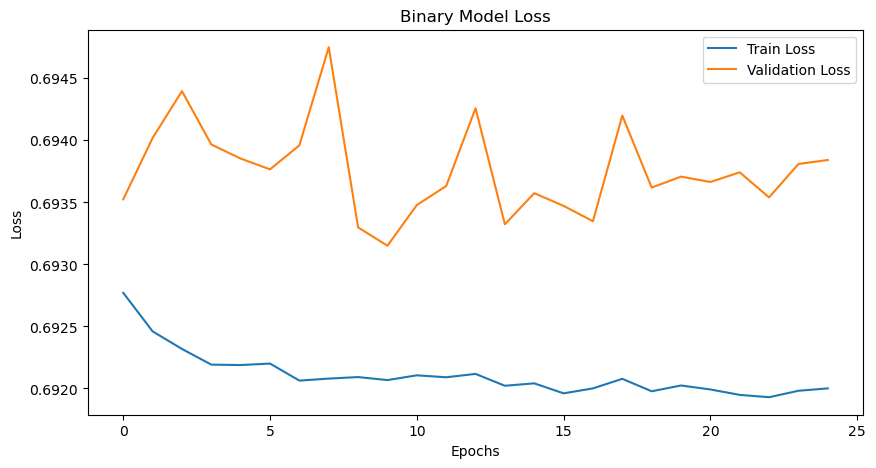

In [27]:
# Plot training and validation loss for the binary model
plt.figure(figsize=(10, 5))
plt.plot(history_binary.history['loss'], label='Train Loss')
plt.plot(history_binary.history['val_loss'], label='Validation Loss')
plt.title('Binary Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

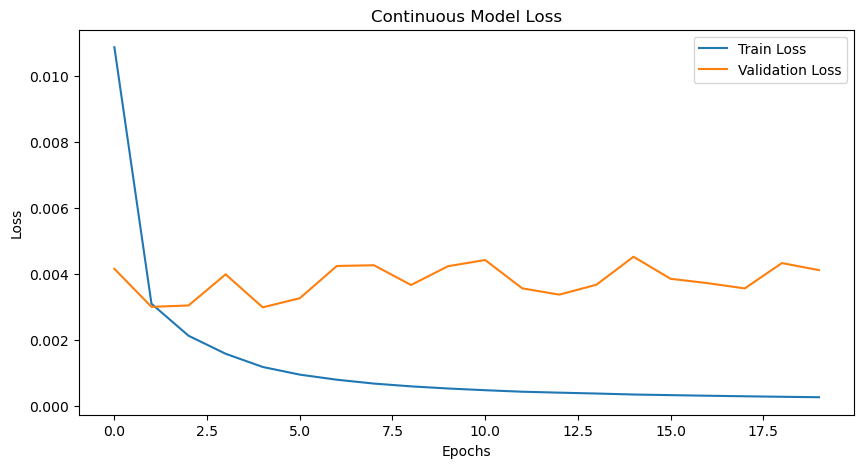

In [28]:
# Plot training and validation loss for the continuous model
plt.figure(figsize=(10, 5))
plt.plot(history_continuous.history['loss'], label='Train Loss')
plt.plot(history_continuous.history['val_loss'], label='Validation Loss')
plt.title('Continuous Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


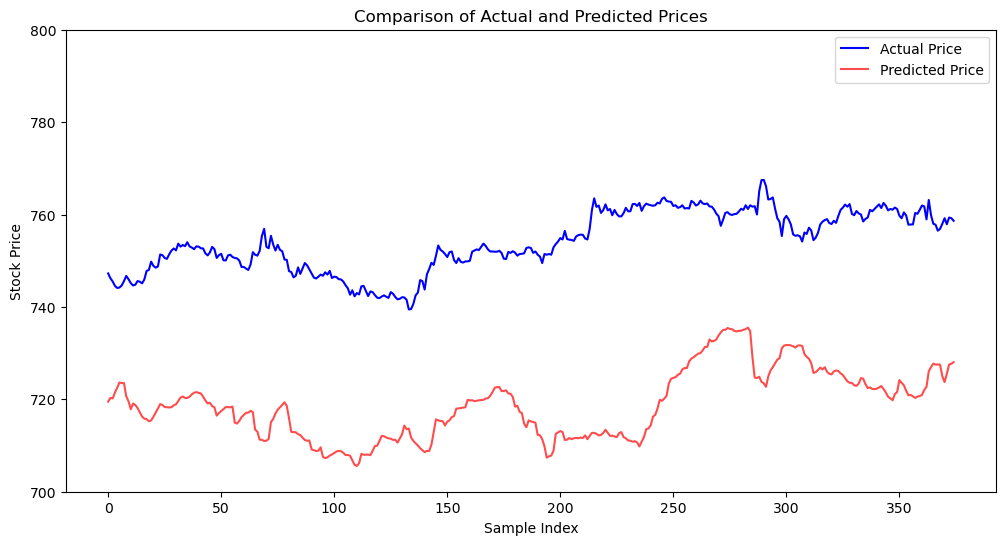

In [29]:
# Rescale the outputs back to the original scale
y_test_continuous_rescaled = close_scaler.inverse_transform(y_test_continuous.reshape(-1, 1))
y_pred_continuous_rescaled = close_scaler.inverse_transform(y_pred_continuous.reshape(-1, 1))

# Visualization of prediction vs actual for the continuous model
plt.figure(figsize=(12, 6))
plt.plot(y_test_continuous_rescaled, label='Actual Price', color='blue')
plt.plot(y_pred_continuous_rescaled, label='Predicted Price', color='red', alpha=0.7)
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.ylim(700, 800)
plt.show()

Continous

In [30]:
init_amount = 10000

In [31]:
def continuous_trading_strategy(init_amount, y_test_continuous_rescaled, y_pred_continuous_rescaled):
    current_balance = init_amount
    stock_units = 0
    num_buys = 0
    num_sells = 0
    total_minutes = (len(y_pred_continuous_rescaled) - 1) * 5  # Each time unit is 5 minutes


    for i in range(len(y_pred_continuous_rescaled) - 1):
        current_price = y_test_continuous_rescaled[i][0]
        current_prediction = y_pred_continuous_rescaled[i][0]
        next_prediction = y_pred_continuous_rescaled[i + 1][0]

        if next_prediction > current_prediction:  # Predicted to go up
            if current_balance >= current_price:  # Check if there's enough balance to buy one unit
                stock_units += 1  # Buy one unit
                current_balance -= current_price  # Subtract the cost of one unit from the balance
                num_buys += 1
            else:
                continue
        elif next_prediction < current_prediction:  # Predicted to go down
            if stock_units > 0:
                current_balance += stock_units * current_price  # Sell all units
                stock_units = 0
                num_sells += 1
                
        

    # Sell any remaining stock units at the last known price
    final_price = y_test_continuous_rescaled[-1][0]
    if stock_units > 0:
        current_balance += stock_units * final_price
        stock_units = 0
        num_sells += 1

    gain_loss_percent = ((current_balance - init_amount) / init_amount) * 100
    
    trading_hours = total_minutes / 60  # Convert total trading minutes to hours

    # Baseline scenario: Buy at the first and sell at the last price
    baseline_first_price = y_test_continuous_rescaled[0][0]
    baseline_final_price = y_test_continuous_rescaled[-1][0]
    baseline_units = init_amount / baseline_first_price
    baseline_final_balance = baseline_units * baseline_final_price
    baseline_gain_loss_percent = ((baseline_final_balance - init_amount) / init_amount) * 100

    print(f"Initial Amount: {init_amount}")
    print(f"Final Balance: {current_balance: .3f}")
    print(f"Total Transactions: {num_buys + num_sells}")
    print(f"Buys: {num_buys}, Sells: {num_sells}")
    print(f"Trading Duration: {trading_hours:.2f} hours")
    if (num_buys + num_sells) > 0:
        print(f"Trades per hour: {(num_buys + num_sells) / trading_hours}")
        print(f"Mean Gain/Loss Percentage per transaction: {gain_loss_percent/(num_buys + num_sells):.5f}%")
    print(f"Gain/Loss Percentage: {gain_loss_percent:.2f}%")
    print("Baseline Scenario:")
    print(f"Baseline Gain/Loss Percentage: {baseline_gain_loss_percent:.2f}%")


In [32]:
continuous_trading_strategy(init_amount, y_test_continuous_rescaled, y_pred_continuous_rescaled)

Initial Amount: 10000
Final Balance:  9977.450
Total Transactions: 257
Buys: 199, Sells: 58
Trading Duration: 31.17 hours
Trades per hour: 8.245989304812834
Mean Gain/Loss Percentage per transaction: -0.00088%
Gain/Loss Percentage: -0.23%
Baseline Scenario:
Baseline Gain/Loss Percentage: 1.53%


In [33]:
def visualize_trading_strategy_continuous(init_amount, y_test_continuous_rescaled, y_pred_continuous_rescaled):
    current_balance = init_amount
    stock_units = 0
    num_buys = 0
    num_sells = 0
    balance_history = [current_balance]
    stock_units_history = [stock_units]
    timestamps = list(range(len(y_pred_continuous_rescaled) + 1))
    buy_points = []
    sell_points = []

    for i in range(len(y_pred_continuous_rescaled) - 1):
        current_price = y_test_continuous_rescaled[i][0]
        current_prediction = y_pred_continuous_rescaled[i][0]
        next_prediction = y_pred_continuous_rescaled[i + 1][0]

        if next_prediction > current_prediction:  # Predicted to go up
            if current_balance >= current_price:  # Check if there's enough balance to buy one unit
                stock_units += 1  # Buy one unit
                current_balance -= current_price  # Subtract the cost of one unit from the balance
                num_buys += 1
                buy_points.append(i)
        elif next_prediction < current_prediction:  # Predicted to go down
            if stock_units > 0:
                current_balance += stock_units * current_price  # Sell all units
                stock_units = 0
                num_sells += 1
                sell_points.append(i)
        
        balance_history.append(current_balance + stock_units * current_price)
        stock_units_history.append(stock_units)

    # Sell any remaining stock units at the last known price
    final_price = y_test_continuous_rescaled[-1][0]
    if stock_units > 0:
        current_balance += stock_units * final_price
        stock_units = 0
        num_sells += 1
        sell_points.append(len(y_pred_continuous_rescaled) - 1)

    balance_history.append(current_balance + stock_units * current_price)
    stock_units_history.append(stock_units)

    gain_loss_percent = ((current_balance - init_amount) / init_amount) * 100

    # Plot the stock price
    plt.figure(figsize=(14, 10))

    plt.subplot(3, 1, 1)
    plt.plot(timestamps[:-1], [price[0] for price in y_test_continuous_rescaled], label='Actual Price')
    plt.scatter(buy_points, [y_test_continuous_rescaled[i][0] for i in buy_points], color='green', label='Buy', marker='^', s=100)
    plt.scatter(sell_points, [y_test_continuous_rescaled[i][0] for i in sell_points], color='red', label='Sell', marker='v', s=100)
    plt.title('Stock Price and Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()

    # Plot the account balance
    plt.subplot(3, 1, 2)
    plt.plot(timestamps, balance_history, label='Balance')
    plt.title('Account Balance Over Time')
    plt.xlabel('Time')
    plt.ylabel('Balance')
    plt.legend()

    # Plot the number of stock units held
    plt.subplot(3, 1, 3)
    plt.plot(timestamps, stock_units_history, label='Stock Units Held')
    plt.title('Stock Units Held Over Time')
    plt.xlabel('Time')
    plt.ylabel('Stock Units')
    plt.legend()

    plt.tight_layout()
    plt.show()


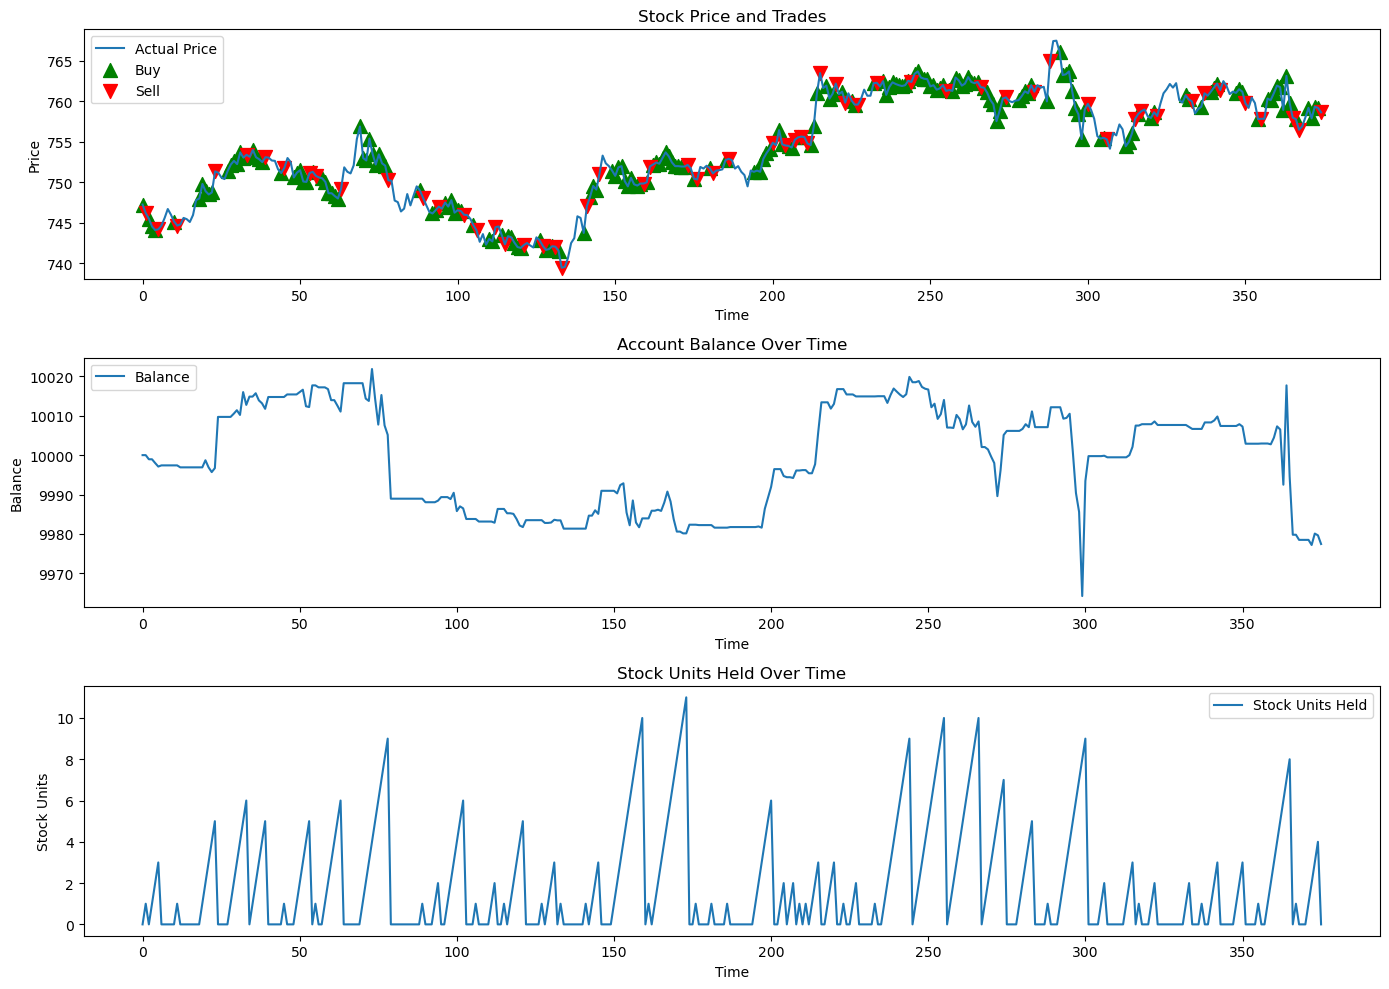

In [34]:
visualize_trading_strategy_continuous(init_amount, y_test_continuous_rescaled, y_pred_continuous_rescaled)

Binary

In [35]:
def binary_trading_strategy(init_amount, y_test_continuous_rescaled, y_pred_binary):
    current_balance = init_amount
    stock_units = 0
    num_buys = 0
    num_sells = 0
    total_minutes = (len(y_pred_binary) - 1) * 5  # Each time unit is 5 minutes

    for i in range(len(y_pred_binary) - 1):
        current_price = y_test_continuous_rescaled[i][0]
        prediction = y_pred_binary[i] > binary_thresh
        
        if prediction == 1:  # Predicted to go up
            if current_balance >= current_price:  # Check if there's enough balance to buy one unit
                stock_units += 1
                current_balance -= current_price
                num_buys += 1
        elif prediction == 0 and stock_units > 0:  # Predicted to go down and we have stock units
            current_balance += stock_units * current_price
            stock_units = 0
            num_sells += 1

    # Sell any remaining stock units at the last known price
    final_price = y_test_continuous_rescaled[-1][0]
    if stock_units > 0:
        current_balance += stock_units * final_price
        stock_units = 0
        num_sells += 1

    gain_loss_percent = ((current_balance - init_amount) / init_amount) * 100
    trading_hours = total_minutes / 60  # Convert total trading minutes to hours

    # Baseline scenario: Buy at the first and sell at the last price
    baseline_first_price = y_test_continuous_rescaled[0][0]
    baseline_final_price = y_test_continuous_rescaled[-1][0]
    baseline_units = init_amount / baseline_first_price
    baseline_final_balance = baseline_units * baseline_final_price
    baseline_gain_loss_percent = ((baseline_final_balance - init_amount) / init_amount) * 100

    if num_buys + num_sells < 1:
        print("No transactions")
        return
    
    print(f"Initial Amount: {init_amount}")
    print(f"Final Balance: {current_balance}")
    print(f"Total Transactions: {num_buys + num_sells}")
    print(f"Buys: {num_buys}, Sells: {num_sells}")
    print(f"Trading Duration: {trading_hours:.2f} hours")
    print(f"Trades per hour: {(num_buys + num_sells) / trading_hours}")
    print(f"Gain/Loss Percentage: {gain_loss_percent:.2f}%")
    print(f"Mean Gain/Loss Percentage per transaction: {gain_loss_percent/(num_buys + num_sells):.5f}%")
    print("Baseline Scenario:")
    print(f"Baseline Gain/Loss Percentage: {baseline_gain_loss_percent:.2f}%")


In [36]:
binary_trading_strategy(init_amount, y_test_continuous_rescaled, y_pred_binary)

Initial Amount: 10000
Final Balance: 10059.599999999999
Total Transactions: 97
Buys: 86, Sells: 11
Trading Duration: 31.17 hours
Trades per hour: 3.1122994652406417
Gain/Loss Percentage: 0.60%
Mean Gain/Loss Percentage per transaction: 0.00614%
Baseline Scenario:
Baseline Gain/Loss Percentage: 1.53%


In [37]:
def visualize_trading_strategy_binary(init_amount, y_test_continuous_rescaled, y_pred_binary):
    current_balance = init_amount
    stock_units = 0
    num_buys = 0
    num_sells = 0
    balance_history = [current_balance]
    stock_units_history = [stock_units]
    timestamps = list(range(len(y_pred_continuous_rescaled) + 1))
    buy_points = []
    sell_points = []

    for i in range(len(y_pred_continuous_rescaled) - 1):
        current_price = y_test_continuous_rescaled[i][0]
        prediction = y_pred_binary[i] > binary_thresh

        if prediction == 1:  # Predicted to go up
            if current_balance >= current_price:  # Check if there's enough balance to buy one unit
                stock_units += 1  # Buy one unit
                current_balance -= current_price  # Subtract the cost of one unit from the balance
                num_buys += 1
                buy_points.append(i)
        elif prediction == 0 and stock_units > 0:  # Predicted to go down and we have stock units
            current_balance += stock_units * current_price  # Sell all units
            stock_units = 0
            num_sells += 1
            sell_points.append(i)
        
        balance_history.append(current_balance + stock_units * current_price)
        stock_units_history.append(stock_units)

    # Sell any remaining stock units at the last known price
    final_price = y_test_continuous_rescaled[-1][0]
    if stock_units > 0:
        current_balance += stock_units * final_price
        stock_units = 0
        num_sells += 1
        sell_points.append(len(y_pred_continuous_rescaled) - 1)

    balance_history.append(current_balance + stock_units * current_price)
    stock_units_history.append(stock_units)

    gain_loss_percent = ((current_balance - init_amount) / init_amount) * 100

    # Plot the stock price
    plt.figure(figsize=(14, 10))

    plt.subplot(3, 1, 1)
    plt.plot(timestamps[:-1], [price[0] for price in y_test_continuous_rescaled], label='Actual Price')
    plt.scatter(buy_points, [y_test_continuous_rescaled[i][0] for i in buy_points], color='green', label='Buy', marker='^', s=100)
    plt.scatter(sell_points, [y_test_continuous_rescaled[i][0] for i in sell_points], color='red', label='Sell', marker='v', s=100)
    plt.title('Stock Price and Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()

    # Plot the account balance
    plt.subplot(3, 1, 2)
    plt.plot(timestamps, balance_history, label='Balance')
    plt.title('Account Balance Over Time')
    plt.xlabel('Time')
    plt.ylabel('Balance')
    plt.legend()

    # Plot the number of stock units held
    plt.subplot(3, 1, 3)
    plt.plot(timestamps, stock_units_history, label='Stock Units Held')
    plt.title('Stock Units Held Over Time')
    plt.xlabel('Time')
    plt.ylabel('Stock Units')
    plt.legend()

    plt.tight_layout()
    plt.show()


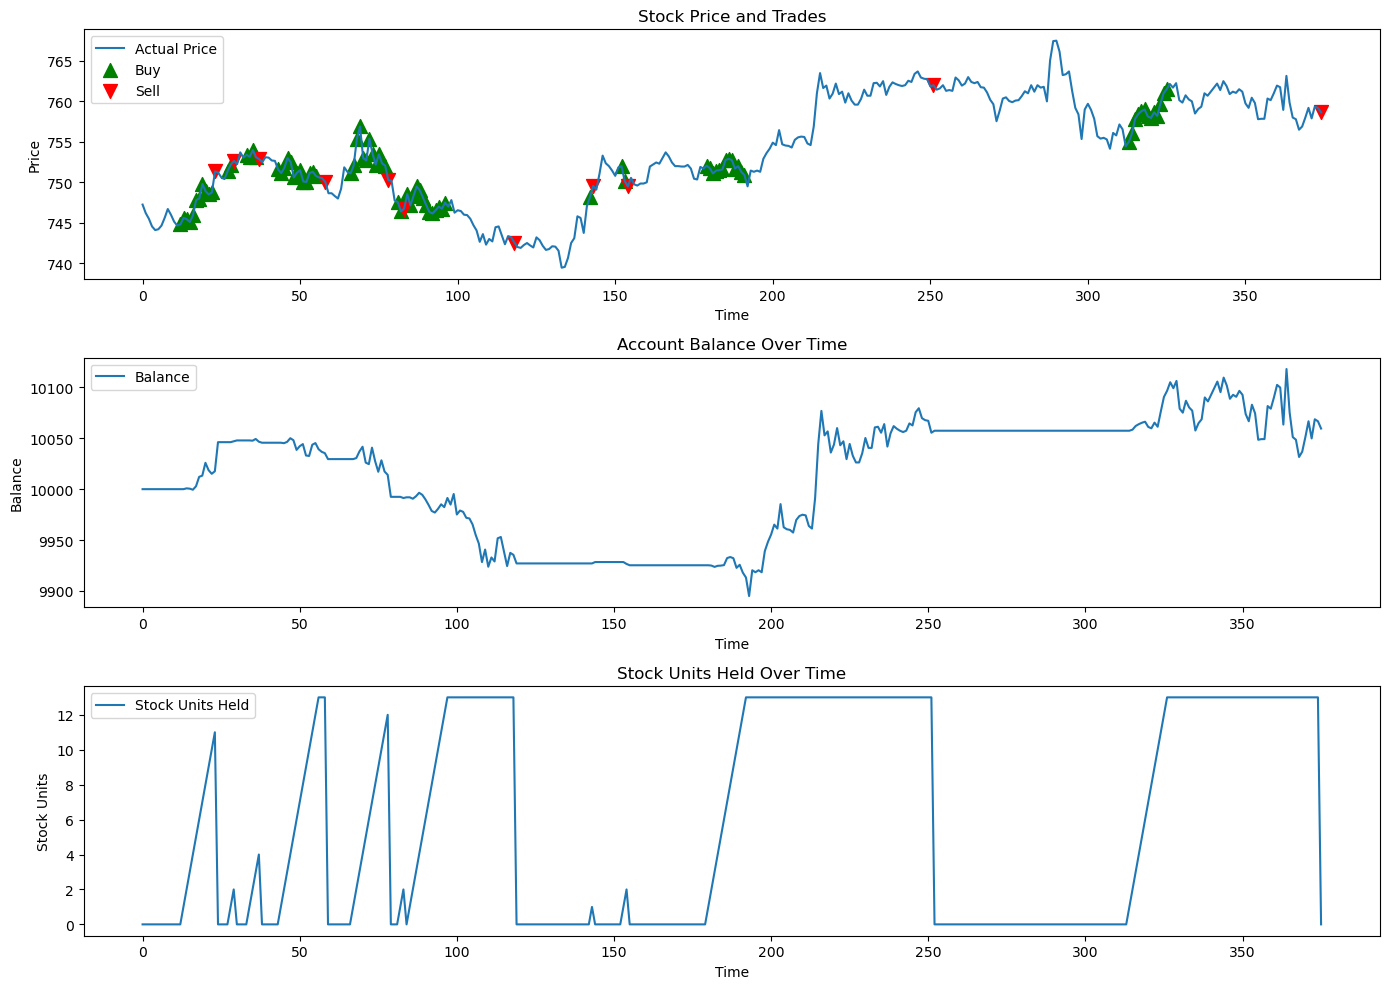

In [38]:
visualize_trading_strategy_binary(init_amount, y_test_continuous_rescaled, y_pred_binary)

Combined

In [39]:
def combined_trading_strategy(init_amount, y_test_continuous_rescaled, y_pred_continuous_rescaled, y_pred_binary):
    current_balance = init_amount
    stock_units = 0
    num_buys = 0
    num_sells = 0
    total_minutes = (len(y_pred_binary) - 1) * 5  # Each time unit is 5 minutes

    for i in range(len(y_pred_binary) - 1):
        current_price = y_test_continuous_rescaled[i][0]
        current_prediction = y_pred_continuous_rescaled[i][0]
        next_prediction = y_pred_continuous_rescaled[i + 1][0]
        prediction_binary = y_pred_binary[i] > binary_thresh

        if prediction_binary == 1 and next_prediction > current_prediction:
            if current_balance >= current_price:
                stock_units += 1
                current_balance -= current_price
                num_buys += 1
        elif prediction_binary == 0 and next_prediction < current_prediction:
            if stock_units > 0:
                current_balance += stock_units * current_price
                stock_units = 0
                num_sells += 1

    # Sell any remaining stock units at the last known price
    final_price = y_test_continuous_rescaled[-1][0]
    if stock_units > 0:
        current_balance += stock_units * final_price
        stock_units = 0
        num_sells += 1

    gain_loss_percent = ((current_balance - init_amount) / init_amount) * 100
    trading_hours = total_minutes / 60  # Convert total trading minutes to hours

    # Baseline scenario: Buy at the first and sell at the last price
    baseline_first_price = y_test_continuous_rescaled[0][0]
    baseline_final_price = y_test_continuous_rescaled[-1][0]
    baseline_units = init_amount / baseline_first_price
    baseline_final_balance = baseline_units * baseline_final_price
    baseline_gain_loss_percent = ((baseline_final_balance - init_amount) / init_amount) * 100
    
    if num_buys + num_sells < 1:
        print("No transactions")
        return

    print(f"Initial Amount: {init_amount}")
    print(f"Final Balance: {current_balance}")
    print(f"Total Transactions: {num_buys + num_sells}")
    print(f"Buys: {num_buys}, Sells: {num_sells}")
    print(f"Trading Duration: {trading_hours:.2f} hours")
    print(f"Trades per hour: {(num_buys + num_sells) / trading_hours}")
    print(f"Gain/Loss Percentage: {gain_loss_percent:.2f}%")
    print(f"Mean Gain/Loss Percentage per transaction: {gain_loss_percent/(num_buys + num_sells):.5f}%")
    print("Baseline Scenario:")
    print(f"Baseline Gain/Loss Percentage: {baseline_gain_loss_percent:.2f}%")


In [40]:
combined_trading_strategy(init_amount, y_test_continuous_rescaled, y_pred_continuous_rescaled, y_pred_binary)

Initial Amount: 10000
Final Balance: 10015.450000000003
Total Transactions: 78
Buys: 69, Sells: 9
Trading Duration: 31.17 hours
Trades per hour: 2.5026737967914436
Gain/Loss Percentage: 0.15%
Mean Gain/Loss Percentage per transaction: 0.00198%
Baseline Scenario:
Baseline Gain/Loss Percentage: 1.53%


## Re train periods
#### Continuous

In [41]:
# Initialize lists to store predictions
predictions_no_retraining = []
predictions_with_retraining = []

In [42]:
# Initial clone of the model for no retraining scenario
model_no_retraining = tf.keras.models.clone_model(model_continuous)
model_no_retraining.set_weights(model_continuous.get_weights())

In [43]:
X, _, y = create_sequences(df_weekly_retrain, seq_len)

In [44]:
fine_tune_learning_rate = 1e-6  # Smaller learning rate for fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=fine_tune_learning_rate)
model_continuous.compile(optimizer=optimizer, loss='mean_squared_error')

Fine tuning using rolling window

In [45]:
rolling_window_size = 3 * mum_units_in_day * 5  # Rolling window size of 3 weeks

In [46]:
# Loop through each week
for week in range(weeks_to_exclude):
    # Calculate the indices for the current week's data
    start_idx = week * test_size
    end_idx = start_idx + test_size
    
    # Extract the test data for the current week
    X_test_week = X[start_idx:end_idx]
    y_test_week = y[start_idx:end_idx]
    
    # Predict without re-training
    pred_no_retrain = model_no_retraining.predict(X_test_week).T[0]
    predictions_no_retraining.append(pred_no_retrain)
    
    if week != 0:
        # For fine-tuning, use data up to the start of the current week's data
        rolling_start_idx = max(0, start_idx - rolling_window_size)

        # Extract the rolling window data (up to the start of the current week)
        X_train_week = X[rolling_start_idx:start_idx]
        y_train_week = y[rolling_start_idx:start_idx]


        # Fine-tune the model on the rolling window data (up to the start of the current week)
        model_continuous.fit(
            X_train_week, y_train_week,
            validation_split=0.15,  # Use the last 15% of the data for validation
            epochs=50,  # Fewer epochs for fine-tuning
            batch_size=32,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
        )

    # Predict with re-training
    pred_with_retrain = model_continuous.predict(X_test_week).T[0]
    predictions_with_retraining.append(pred_with_retrain)

    # Save the updated model after each week's training
    model_continuous.save(f'continuous_model_week_{week + 1}.h5')


2024-06-08 11:18:37.340122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 135ms/step


2024-06-08 11:18:39.383048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 116ms/step
Epoch 1/50


2024-06-08 11:18:43.826222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.0036

2024-06-08 11:18:48.967970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 7s 511ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 2/50
10/10 [==============================] - 3s 313ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 3/50
10/10 [==============================] - 3s 301ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 4/50
10/10 [==============================] - 3s 272ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 5/50
10/10 [==============================] - 3s 277ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 6/50
10/10 [==============================] - 3s 308ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 7/50
10/10 [==============================] - 3s 270ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 8/50
10/10 [==============================] - 3s 275ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 9/50
10/10 [==============================] - 3s 274ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 10/50
10/10 [==============================] - 3s 283ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 11/5

Epoch 3/50
30/30 [==============================] - 8s 275ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 4/50
30/30 [==============================] - 8s 276ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 5/50
30/30 [==============================] - 8s 268ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 6/50
12/12 [==============================] - 1s 118ms/step
Epoch 1/50
30/30 [==============================] - 8s 265ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 2/50
30/30 [==============================] - 8s 272ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 3/50
30/30 [==============================] - 8s 264ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 4/50
30/30 [==============================] - 8s 272ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 5/50
30/30 [==============================] - 8s 271ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 6/50
12/12 [==============================] - 1s 114ms/step
Epoch 1/50
30/30 [==============================] - 8s 274ms/step - 

In [47]:
# Flatten the predictions and true values for comparison
predictions_no_retraining_flat = np.concatenate(predictions_no_retraining)
predictions_with_retraining_flat = np.concatenate(predictions_with_retraining)
y_test_continuous_flat = np.concatenate([y[i * test_size: (i + 1) * test_size] for i in range(weeks_to_exclude)])

In [48]:
# Assuming you have a scaler to inverse transform the predictions and true values
y_test_continuous_rescaled = close_scaler.inverse_transform(y_test_continuous_flat.reshape(-1, 1))
predictions_no_retraining_rescaled = close_scaler.inverse_transform(predictions_no_retraining_flat.reshape(-1, 1))
predictions_with_retraining_rescaled = close_scaler.inverse_transform(predictions_with_retraining_flat.reshape(-1, 1))

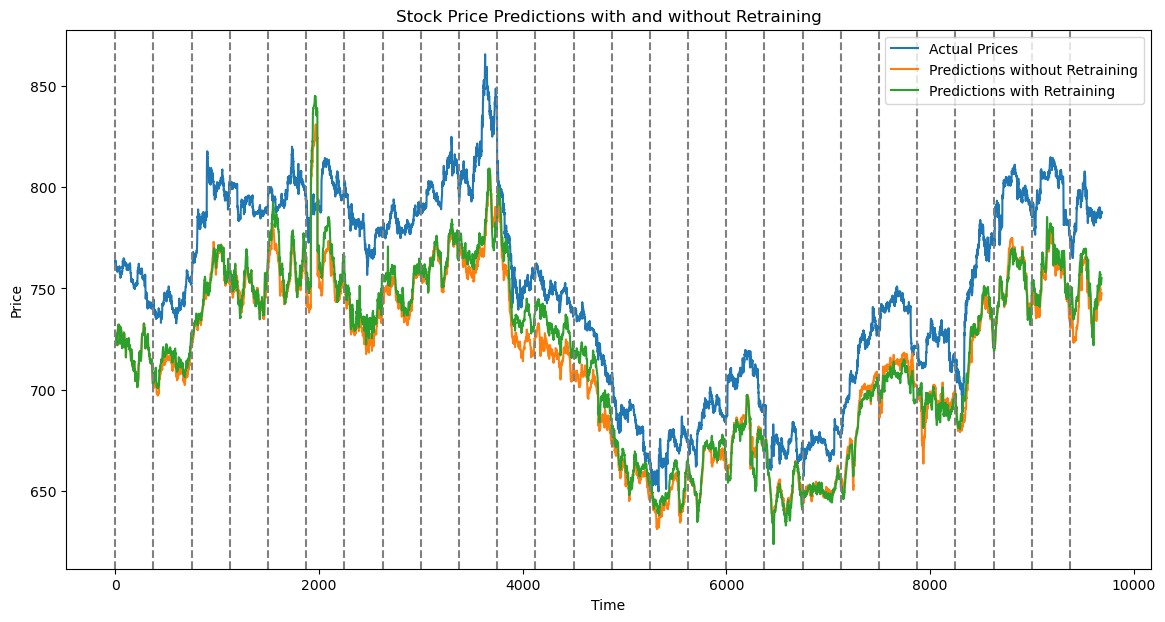

In [49]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_continuous_rescaled, label='Actual Prices')
plt.plot(predictions_no_retraining_rescaled, label='Predictions without Retraining')
plt.plot(predictions_with_retraining_rescaled, label='Predictions with Retraining')

# Add vertical lines to split weeks
for week in range(weeks_to_exclude):
    plt.axvline(x=week * test_size, color='gray', linestyle='--')

plt.title('Stock Price Predictions with and without Retraining')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [50]:
print("Without Retraining:")
continuous_trading_strategy(init_amount, y_test_continuous_rescaled, predictions_no_retraining_rescaled)
print()
print("With Retraining:")
continuous_trading_strategy(init_amount, y_test_continuous_rescaled, predictions_with_retraining_rescaled)

Without Retraining:
Initial Amount: 10000
Final Balance:  9759.750
Total Transactions: 6428
Buys: 4743, Sells: 1685
Trading Duration: 807.08 hours
Trades per hour: 7.964481156427465
Mean Gain/Loss Percentage per transaction: -0.00037%
Gain/Loss Percentage: -2.40%
Baseline Scenario:
Baseline Gain/Loss Percentage: 3.18%

With Retraining:
Initial Amount: 10000
Final Balance:  9758.500
Total Transactions: 6563
Buys: 4829, Sells: 1734
Trading Duration: 807.08 hours
Trades per hour: 8.131750129065566
Mean Gain/Loss Percentage per transaction: -0.00037%
Gain/Loss Percentage: -2.41%
Baseline Scenario:
Baseline Gain/Loss Percentage: 3.18%


Without Retraining:


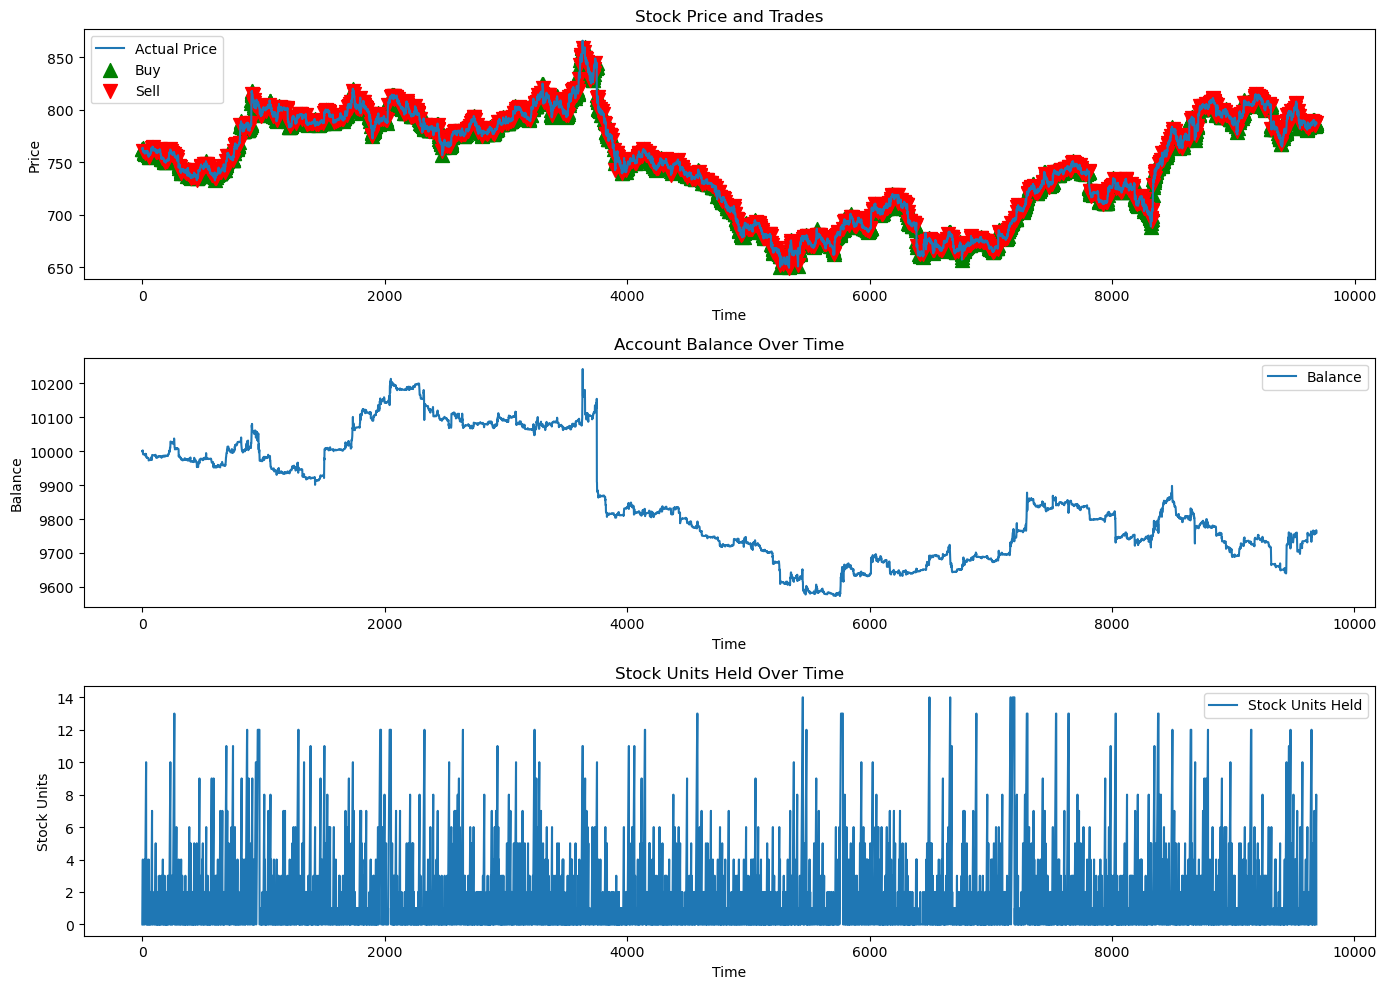


With Retraining:


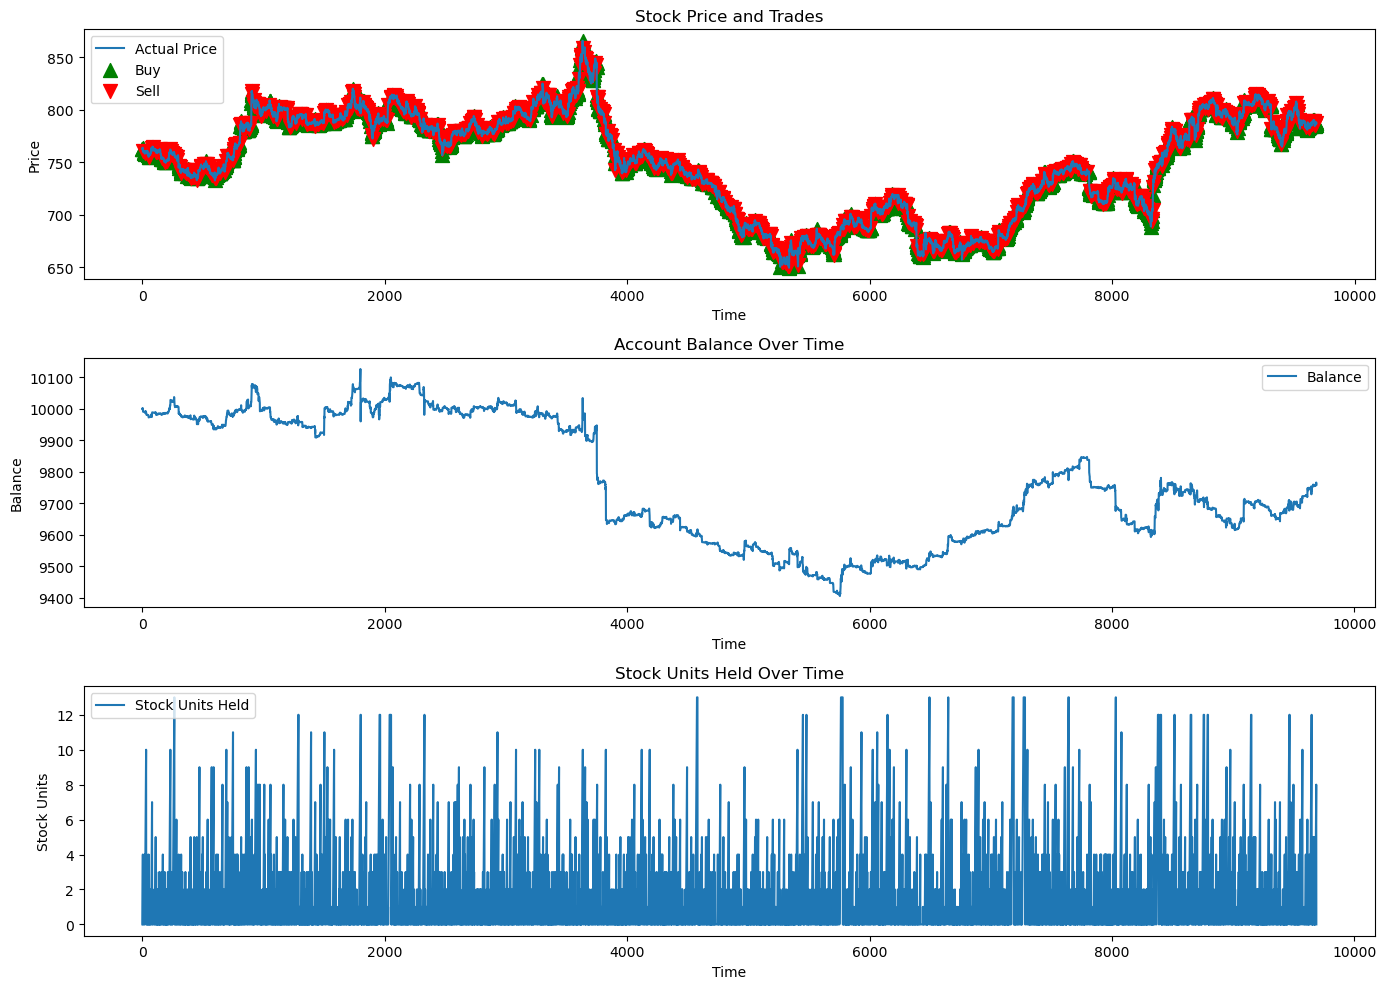

In [51]:
print("Without Retraining:")
visualize_trading_strategy_continuous(init_amount, y_test_continuous_rescaled, predictions_no_retraining_rescaled)
print()
print("With Retraining:")
visualize_trading_strategy_continuous(init_amount, y_test_continuous_rescaled, predictions_with_retraining_rescaled)

Second week (one retrain only)

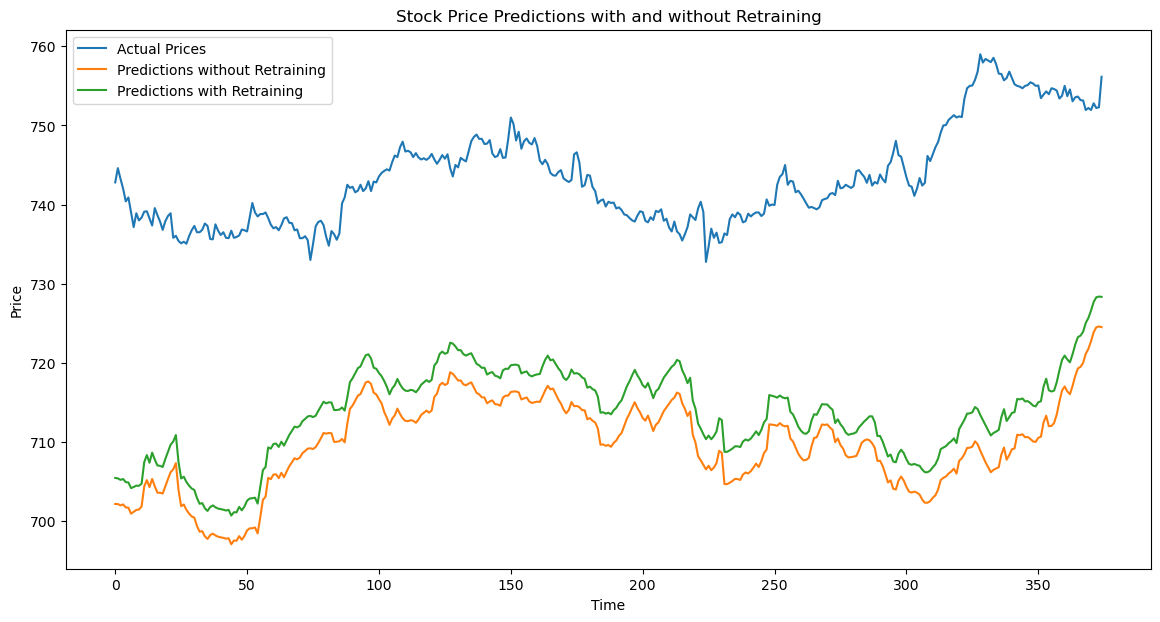

In [52]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_continuous_rescaled[375:375*2], label='Actual Prices')
plt.plot(predictions_no_retraining_rescaled[375:375*2], label='Predictions without Retraining')
plt.plot(predictions_with_retraining_rescaled[375:375*2], label='Predictions with Retraining')


plt.title('Stock Price Predictions with and without Retraining')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

Without Retraining:


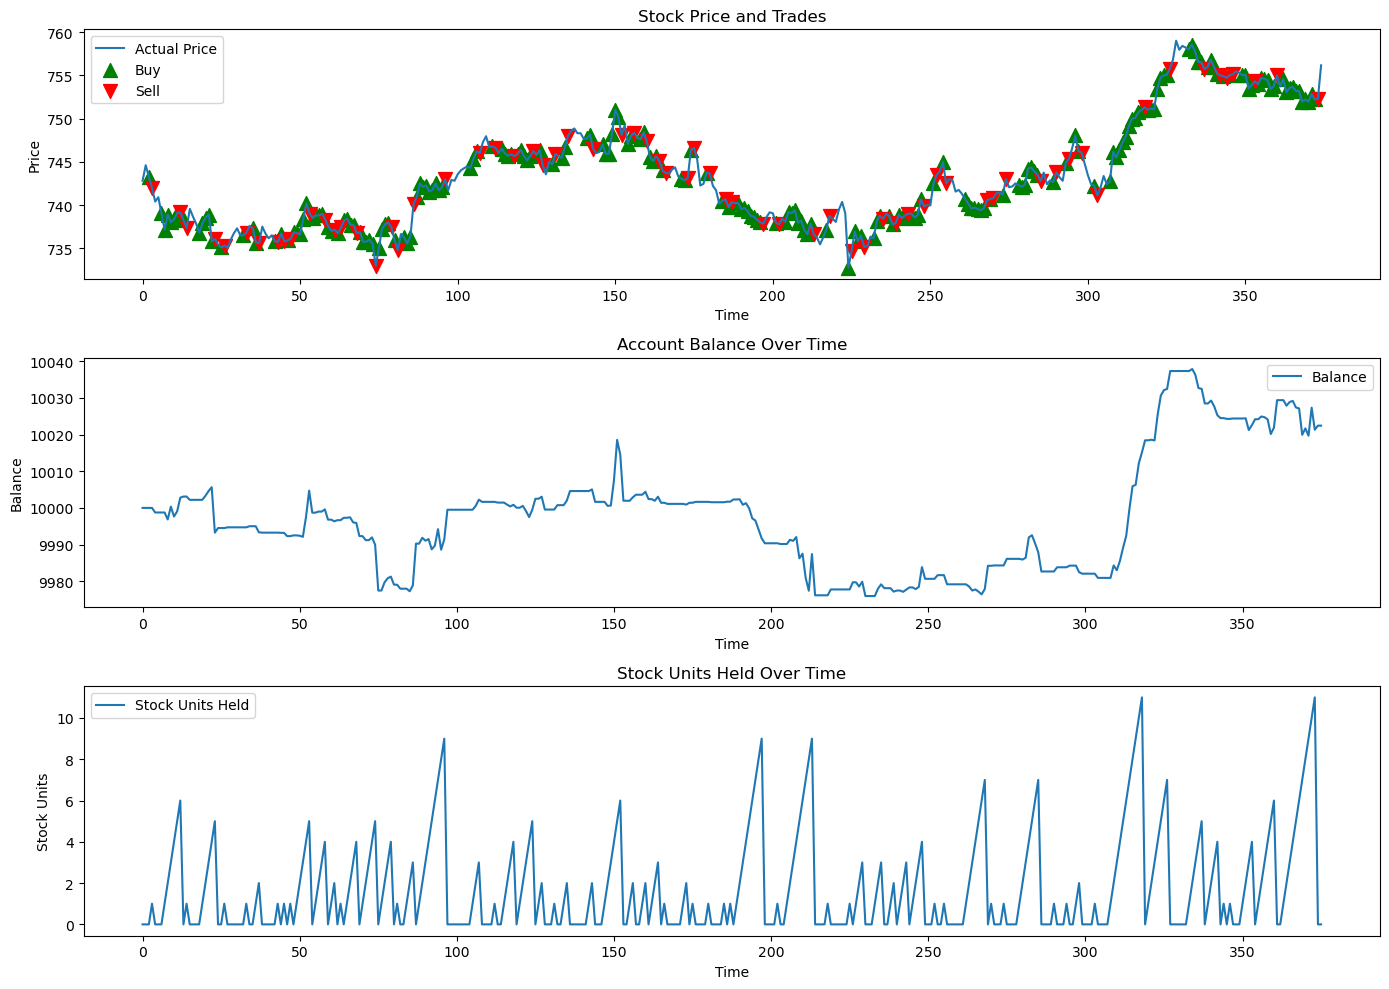


With Retraining:


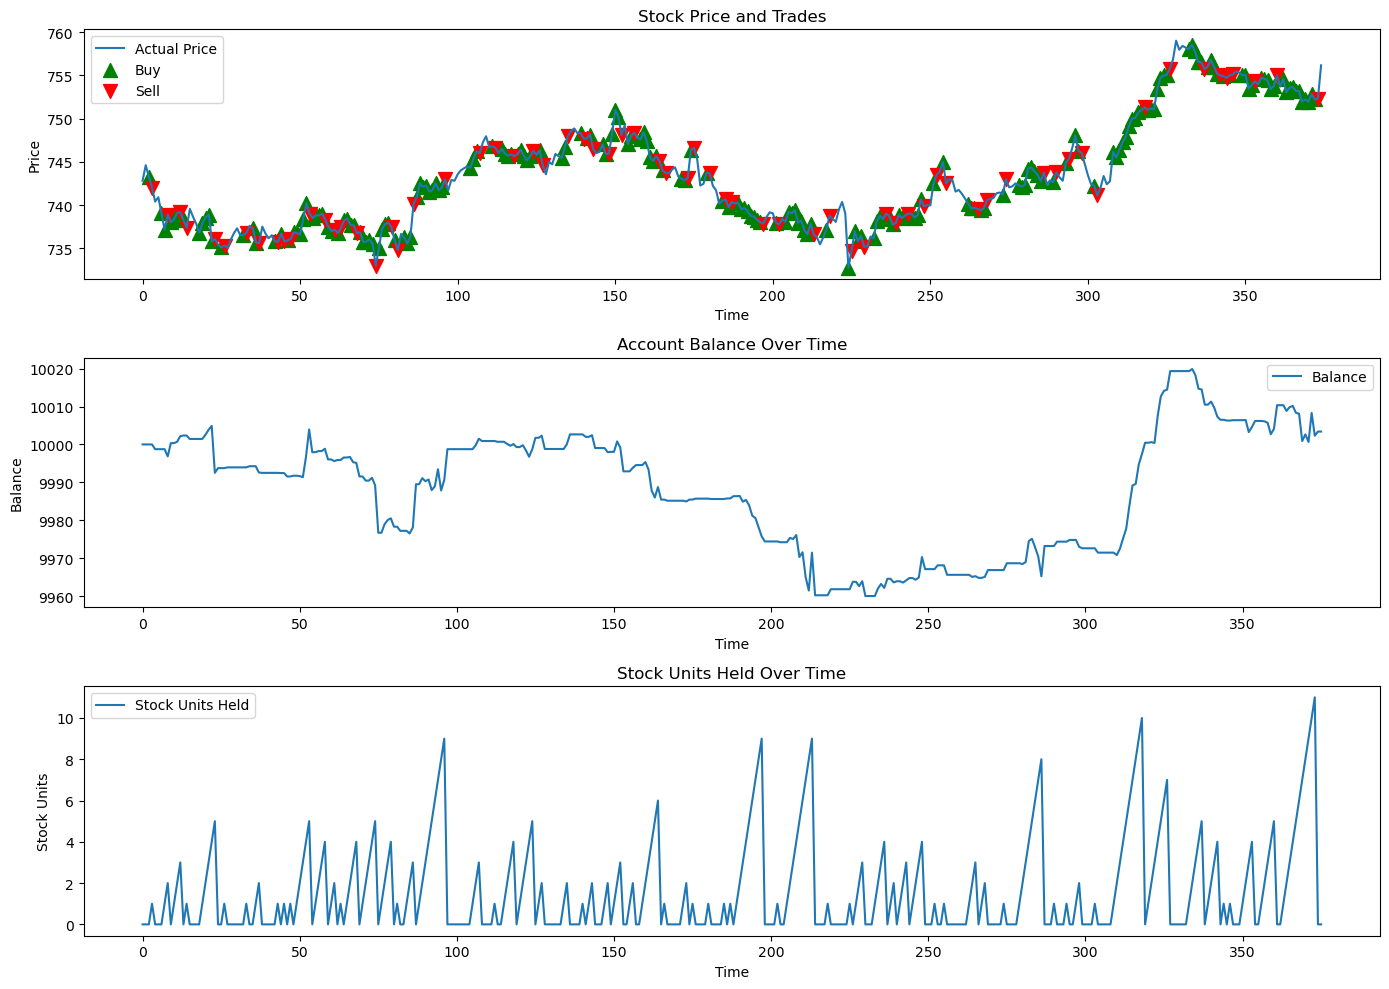

In [53]:
print("Without Retraining:")
visualize_trading_strategy_continuous(init_amount, y_test_continuous_rescaled[test_size:test_size*2], predictions_no_retraining_rescaled[test_size:test_size*2])
print()
print("With Retraining:")
visualize_trading_strategy_continuous(init_amount, y_test_continuous_rescaled[test_size:test_size*2], predictions_with_retraining_rescaled[test_size:test_size*2])

In [54]:
print("Without Retraining:")
continuous_trading_strategy(init_amount, y_test_continuous_rescaled[test_size:test_size*2], predictions_no_retraining_rescaled[test_size:test_size*2])
print()
print("With Retraining:")
continuous_trading_strategy(init_amount, y_test_continuous_rescaled[test_size:test_size*2], predictions_with_retraining_rescaled[test_size:test_size*2])

Without Retraining:
Initial Amount: 10000
Final Balance:  10022.450
Total Transactions: 274
Buys: 207, Sells: 67
Trading Duration: 31.17 hours
Trades per hour: 8.79144385026738
Mean Gain/Loss Percentage per transaction: 0.00082%
Gain/Loss Percentage: 0.22%
Baseline Scenario:
Baseline Gain/Loss Percentage: 1.80%

With Retraining:
Initial Amount: 10000
Final Balance:  10003.400
Total Transactions: 271
Buys: 203, Sells: 68
Trading Duration: 31.17 hours
Trades per hour: 8.695187165775401
Mean Gain/Loss Percentage per transaction: 0.00013%
Gain/Loss Percentage: 0.03%
Baseline Scenario:
Baseline Gain/Loss Percentage: 1.80%


last week

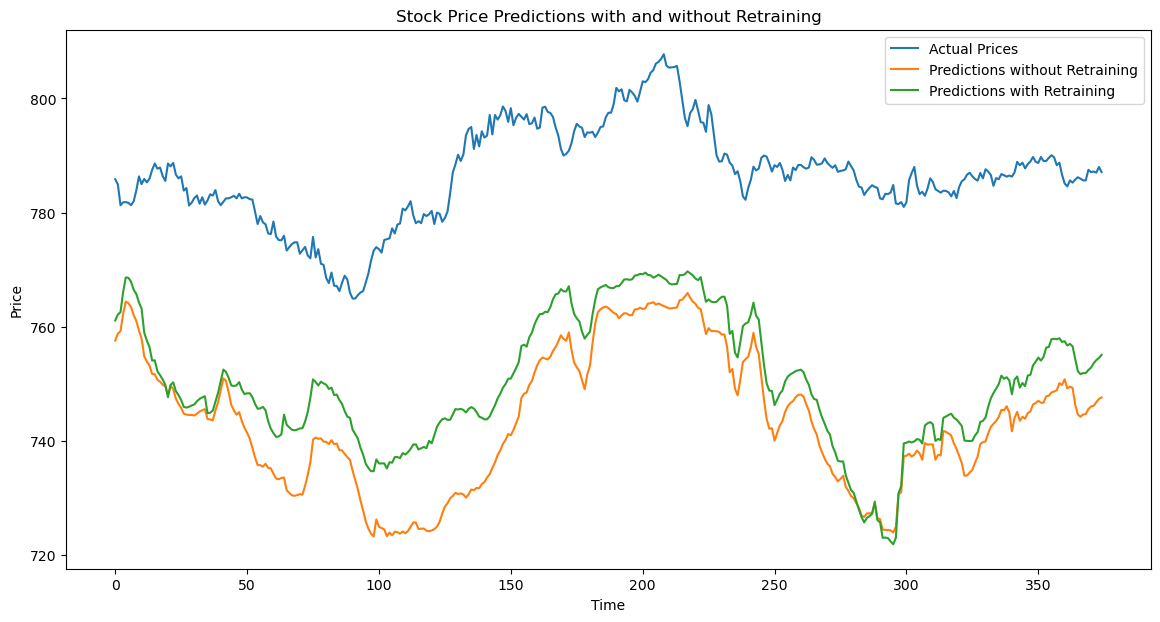

In [55]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_continuous_rescaled[-375:], label='Actual Prices')
plt.plot(predictions_no_retraining_rescaled[-375:], label='Predictions without Retraining')
plt.plot(predictions_with_retraining_rescaled[-375:], label='Predictions with Retraining')


plt.title('Stock Price Predictions with and without Retraining')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

Without Retraining:


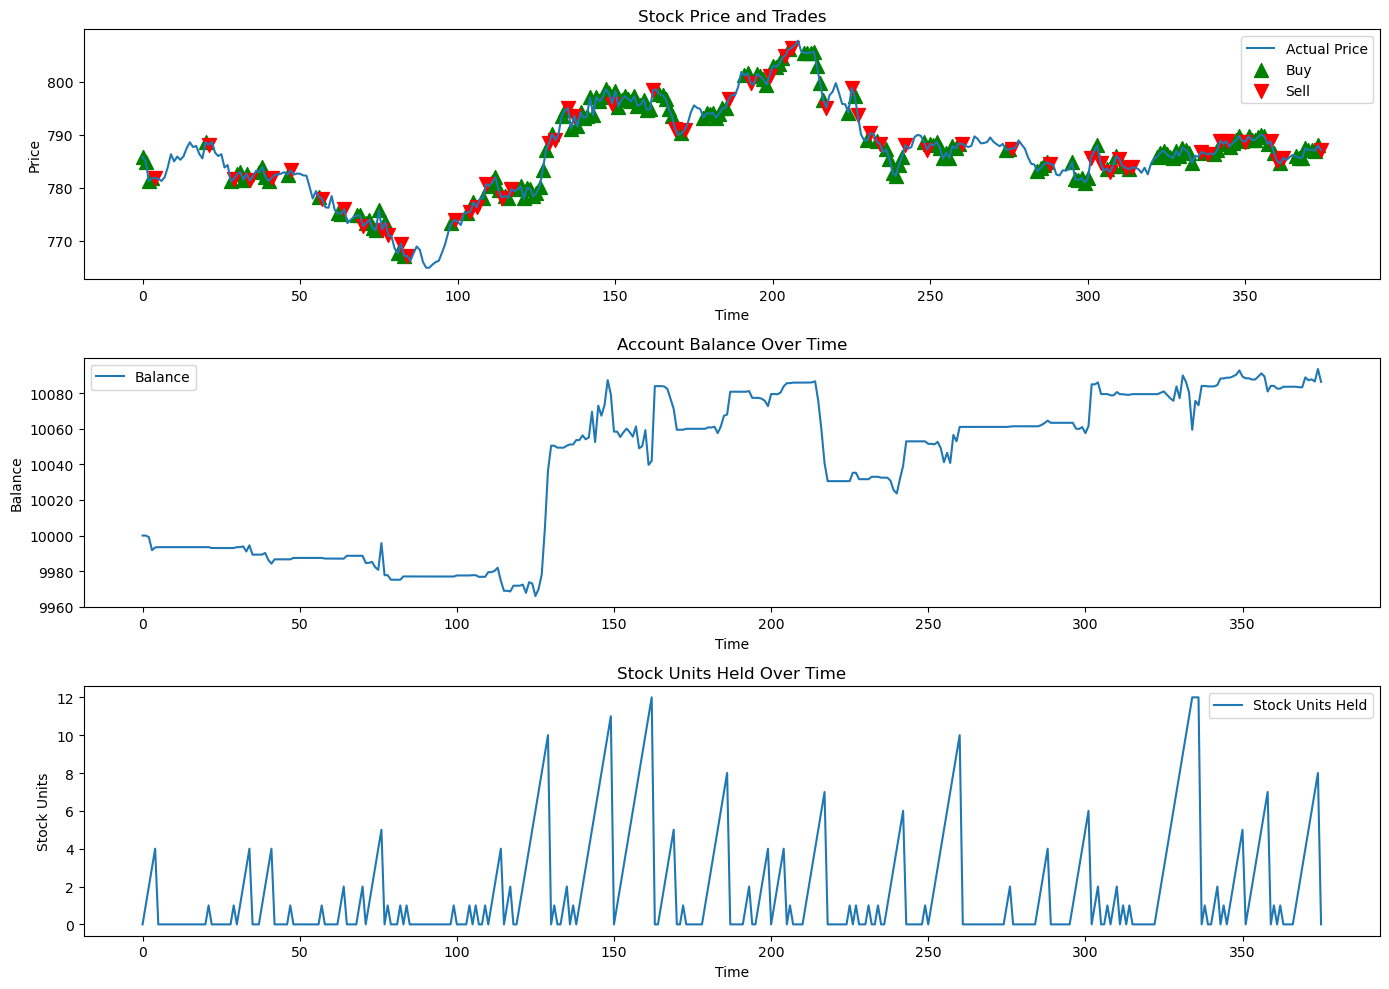


With Retraining:


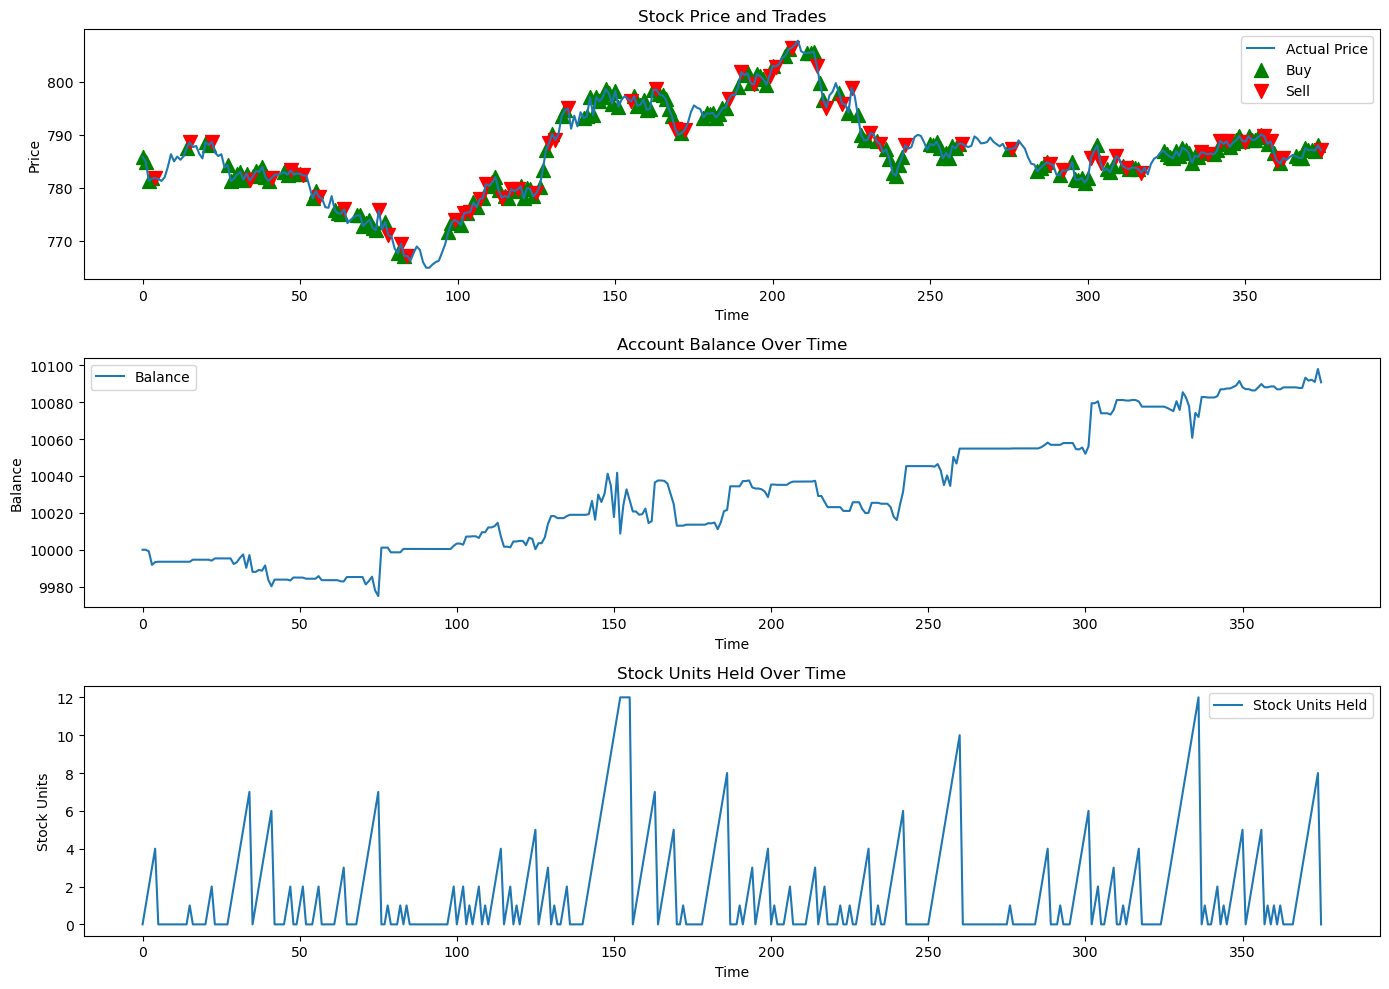

In [56]:
print("Without Retraining:")
visualize_trading_strategy_continuous(init_amount, y_test_continuous_rescaled[-test_size:], predictions_no_retraining_rescaled[-test_size:])
print()
print("With Retraining:")
visualize_trading_strategy_continuous(init_amount, y_test_continuous_rescaled[-test_size:], predictions_with_retraining_rescaled[-test_size:])

In [57]:
print("Without Retraining:")
continuous_trading_strategy(init_amount, y_test_continuous_rescaled[-test_size:], predictions_no_retraining_rescaled[-test_size:])
print()
print("With Retraining:")
continuous_trading_strategy(init_amount, y_test_continuous_rescaled[-test_size:], predictions_with_retraining_rescaled[-test_size:])

Without Retraining:
Initial Amount: 10000
Final Balance:  10086.300
Total Transactions: 242
Buys: 185, Sells: 57
Trading Duration: 31.17 hours
Trades per hour: 7.764705882352941
Mean Gain/Loss Percentage per transaction: 0.00357%
Gain/Loss Percentage: 0.86%
Baseline Scenario:
Baseline Gain/Loss Percentage: 0.16%

With Retraining:
Initial Amount: 10000
Final Balance:  10090.800
Total Transactions: 257
Buys: 196, Sells: 61
Trading Duration: 31.17 hours
Trades per hour: 8.245989304812834
Mean Gain/Loss Percentage per transaction: 0.00353%
Gain/Loss Percentage: 0.91%
Baseline Scenario:
Baseline Gain/Loss Percentage: 0.16%


## Derivative accuracy

In [58]:
def to_binary_classification(prices):
    prices = prices.flatten()
    return np.where(np.diff(prices, prepend=prices[0]) > 0, 1, 0)

In [59]:
y_test_binary = to_binary_classification(y_test_continuous_rescaled)
predictions_no_retraining_binary = to_binary_classification(predictions_no_retraining_rescaled)
predictions_with_retraining_binary = to_binary_classification(predictions_with_retraining_rescaled)

In [60]:
classification_report_no_retraining = classification_report(y_test_binary, predictions_no_retraining_binary)

# Calculate classification metrics for predictions with retraining
classification_report_with_retraining = classification_report(y_test_binary, predictions_with_retraining_binary)

# Print the results
print("Classification Report for Predictions without Retraining:")
print(classification_report_no_retraining)

print("\nClassification Report for Predictions with Retraining:")
print(classification_report_with_retraining)

Classification Report for Predictions without Retraining:
              precision    recall  f1-score   support

           0       0.53      0.51      0.52      4993
           1       0.49      0.51      0.50      4693

    accuracy                           0.51      9686
   macro avg       0.51      0.51      0.51      9686
weighted avg       0.51      0.51      0.51      9686


Classification Report for Predictions with Retraining:
              precision    recall  f1-score   support

           0       0.52      0.49      0.51      4993
           1       0.49      0.51      0.50      4693

    accuracy                           0.50      9686
   macro avg       0.50      0.50      0.50      9686
weighted avg       0.50      0.50      0.50      9686



#### Binary

In [61]:
K.clear_session()
model_binary = tf.keras.models.load_model('binary_model.h5')

In [62]:
# Initialize lists to store predictions
predictions_no_retraining = []
predictions_with_retraining = []

In [63]:
# Initial clone of the model for no retraining scenario
model_no_retraining = tf.keras.models.clone_model(model_binary)
model_no_retraining.set_weights(model_binary.get_weights())

In [64]:
X, y, _ = create_sequences(df_weekly_retrain, seq_len)

In [65]:
fine_tune_learning_rate = 1e-6  # Smaller learning rate for fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=fine_tune_learning_rate)
model_binary.compile(optimizer=optimizer, loss='binary_crossentropy')

Fine tuning using rolling window

In [66]:
rolling_window_size = 3 * mum_units_in_day * 5  # Rolling window size of 3 weeks

In [67]:
# Loop through each week
for week in range(weeks_to_exclude):
    # Calculate the indices for the current week's data
    start_idx = week * test_size
    end_idx = start_idx + test_size
    
    # Extract the test data for the current week
    X_test_week = X[start_idx:end_idx]
    y_test_week = y[start_idx:end_idx]
    
    # Predict without re-training
    pred_no_retrain = model_no_retraining.predict(X_test_week).T[0]
    predictions_no_retraining.append(pred_no_retrain)
    
    if week != 0:
        # For fine-tuning, use data up to the start of the current week's data
        rolling_start_idx = max(0, start_idx - rolling_window_size)

        # Extract the rolling window data (up to the start of the current week)
        X_train_week = X[rolling_start_idx:start_idx]
        y_train_week = y[rolling_start_idx:start_idx]


        # Fine-tune the model on the rolling window data (up to the start of the current week)
        model_binary.fit(
            X_train_week, y_train_week,
            validation_split=0.15,  # Use the last 15% of the data for validation
            epochs=50,  # Fewer epochs for fine-tuning
            batch_size=32,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
        )

    # Predict with re-training
    pred_with_retrain = model_binary.predict(X_test_week).T[0]
    predictions_with_retraining.append(pred_with_retrain)

    # Save the updated model after each week's training
    model_binary.save(f'binary_model_week_{week + 1}.h5')


2024-06-08 11:48:15.013434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 3s 165ms/step


2024-06-08 11:48:17.635057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 120ms/step
Epoch 1/50


2024-06-08 11:48:22.718662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.6899

2024-06-08 11:48:28.758936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 559ms/step - loss: 0.6899 - val_loss: 0.6962
Epoch 2/50
10/10 [==============================] - 3s 314ms/step - loss: 0.6874 - val_loss: 0.6963
Epoch 3/50
10/10 [==============================] - 3s 289ms/step - loss: 0.6870 - val_loss: 0.6964
Epoch 4/50
10/10 [==============================] - 3s 290ms/step - loss: 0.6895 - val_loss: 0.6965
Epoch 5/50
10/10 [==============================] - 3s 274ms/step - loss: 0.6898 - val_loss: 0.6966
Epoch 6/50
12/12 [==============================] - 1s 123ms/step
Epoch 1/50
20/20 [==============================] - 7s 367ms/step - loss: 0.6921 - val_loss: 0.6955
Epoch 2/50
20/20 [==============================] - 6s 282ms/step - loss: 0.6923 - val_loss: 0.6954
Epoch 3/50
20/20 [==============================] - 6s 287ms/step - loss: 0.6915 - val_loss: 0.6954
Epoch 4/50
20/20 [==============================] - 5s 276ms/step - loss: 0.6910 - val_loss: 0.6954
Epoch 5/50
20/20 [===========================

30/30 [==============================] - 8s 274ms/step - loss: 0.6944 - val_loss: 0.6951
Epoch 38/50
30/30 [==============================] - 8s 264ms/step - loss: 0.6954 - val_loss: 0.6951
Epoch 39/50
30/30 [==============================] - 8s 277ms/step - loss: 0.6950 - val_loss: 0.6951
Epoch 40/50
30/30 [==============================] - 8s 267ms/step - loss: 0.6955 - val_loss: 0.6950
Epoch 41/50
30/30 [==============================] - 8s 269ms/step - loss: 0.6947 - val_loss: 0.6950
Epoch 42/50
30/30 [==============================] - 8s 272ms/step - loss: 0.6947 - val_loss: 0.6950
Epoch 43/50
30/30 [==============================] - 8s 266ms/step - loss: 0.6959 - val_loss: 0.6949
Epoch 44/50
30/30 [==============================] - 8s 279ms/step - loss: 0.6948 - val_loss: 0.6949
Epoch 45/50
30/30 [==============================] - 8s 265ms/step - loss: 0.6941 - val_loss: 0.6948
Epoch 46/50
30/30 [==============================] - 8s 275ms/step - loss: 0.6945 - val_loss: 0.6948
Ep

30/30 [==============================] - 9s 290ms/step - loss: 0.6944 - val_loss: 0.6934
Epoch 3/50
30/30 [==============================] - 8s 280ms/step - loss: 0.6952 - val_loss: 0.6933
Epoch 4/50
30/30 [==============================] - 9s 287ms/step - loss: 0.6939 - val_loss: 0.6933
Epoch 5/50
30/30 [==============================] - 10s 317ms/step - loss: 0.6928 - val_loss: 0.6933
Epoch 6/50
30/30 [==============================] - 8s 274ms/step - loss: 0.6937 - val_loss: 0.6933
Epoch 7/50
30/30 [==============================] - 8s 274ms/step - loss: 0.6937 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 8s 257ms/step - loss: 0.6936 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 8s 272ms/step - loss: 0.6937 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 8s 260ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 11/50
30/30 [==============================] - 8s 265ms/step - loss: 0.6939 - val_loss: 0.6932
Epoch 12

30/30 [==============================] - 8s 266ms/step - loss: 0.6916 - val_loss: 0.6955
Epoch 4/50
30/30 [==============================] - 8s 257ms/step - loss: 0.6921 - val_loss: 0.6954
Epoch 5/50
30/30 [==============================] - 8s 270ms/step - loss: 0.6918 - val_loss: 0.6954
Epoch 6/50
30/30 [==============================] - 8s 262ms/step - loss: 0.6921 - val_loss: 0.6953
Epoch 7/50
30/30 [==============================] - 8s 265ms/step - loss: 0.6917 - val_loss: 0.6953
Epoch 8/50
30/30 [==============================] - 8s 256ms/step - loss: 0.6904 - val_loss: 0.6953
Epoch 9/50
30/30 [==============================] - 8s 267ms/step - loss: 0.6905 - val_loss: 0.6952
Epoch 10/50
30/30 [==============================] - 8s 266ms/step - loss: 0.6909 - val_loss: 0.6952
Epoch 11/50
30/30 [==============================] - 8s 265ms/step - loss: 0.6915 - val_loss: 0.6952
Epoch 12/50
30/30 [==============================] - 8s 266ms/step - loss: 0.6916 - val_loss: 0.6952
Epoch 13

30/30 [==============================] - 8s 261ms/step - loss: 0.6930 - val_loss: 0.6928
Epoch 37/50
30/30 [==============================] - 8s 262ms/step - loss: 0.6918 - val_loss: 0.6928
Epoch 38/50
30/30 [==============================] - 8s 257ms/step - loss: 0.6935 - val_loss: 0.6928
Epoch 39/50
30/30 [==============================] - 8s 266ms/step - loss: 0.6934 - val_loss: 0.6928
Epoch 40/50
30/30 [==============================] - 8s 259ms/step - loss: 0.6927 - val_loss: 0.6928
Epoch 41/50
30/30 [==============================] - 8s 271ms/step - loss: 0.6931 - val_loss: 0.6928
Epoch 42/50
30/30 [==============================] - 8s 261ms/step - loss: 0.6933 - val_loss: 0.6928
Epoch 43/50
30/30 [==============================] - 8s 268ms/step - loss: 0.6938 - val_loss: 0.6927
Epoch 44/50
30/30 [==============================] - 8s 259ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 45/50
30/30 [==============================] - 8s 267ms/step - loss: 0.6933 - val_loss: 0.6927
Ep

In [68]:
# Flatten the predictions and true values for comparison
predictions_no_retraining_flat = np.concatenate(predictions_no_retraining)
predictions_with_retraining_flat = np.concatenate(predictions_with_retraining)
y_test_binary_flat = np.concatenate([y[i * test_size: (i + 1) * test_size] for i in range(weeks_to_exclude)])

In [69]:
print("Without Retraining:")
binary_trading_strategy(init_amount, y_test_continuous_rescaled, predictions_no_retraining_flat)
print()
print("With Retraining:")
binary_trading_strategy(init_amount, y_test_continuous_rescaled, predictions_with_retraining_flat)

Without Retraining:
Initial Amount: 10000
Final Balance: 9887.049999999987
Total Transactions: 915
Buys: 818, Sells: 97
Trading Duration: 807.08 hours
Trades per hour: 1.1337119256582344
Gain/Loss Percentage: -1.13%
Mean Gain/Loss Percentage per transaction: -0.00123%
Baseline Scenario:
Baseline Gain/Loss Percentage: 3.18%

With Retraining:
Initial Amount: 10000
Final Balance: 9807.000000000015
Total Transactions: 892
Buys: 796, Sells: 96
Trading Duration: 807.08 hours
Trades per hour: 1.1052142488384098
Gain/Loss Percentage: -1.93%
Mean Gain/Loss Percentage per transaction: -0.00216%
Baseline Scenario:
Baseline Gain/Loss Percentage: 3.18%


In [70]:
print("Without Retraining:")
binary_trading_strategy(init_amount, y_test_continuous_rescaled[test_size:test_size*2], predictions_no_retraining_flat[test_size:test_size*2])
print()
print("With Retraining:")
binary_trading_strategy(init_amount, y_test_continuous_rescaled[test_size:test_size*2], predictions_with_retraining_flat[test_size:test_size*2])

Without Retraining:
Initial Amount: 10000
Final Balance: 10050.949999999995
Total Transactions: 57
Buys: 50, Sells: 7
Trading Duration: 31.17 hours
Trades per hour: 1.8288770053475936
Gain/Loss Percentage: 0.51%
Mean Gain/Loss Percentage per transaction: 0.00894%
Baseline Scenario:
Baseline Gain/Loss Percentage: 1.80%

With Retraining:
Initial Amount: 10000
Final Balance: 10057.9
Total Transactions: 57
Buys: 51, Sells: 6
Trading Duration: 31.17 hours
Trades per hour: 1.8288770053475936
Gain/Loss Percentage: 0.58%
Mean Gain/Loss Percentage per transaction: 0.01016%
Baseline Scenario:
Baseline Gain/Loss Percentage: 1.80%


In [71]:
print("Without Retraining:")
binary_trading_strategy(init_amount, y_test_continuous_rescaled[-test_size:], predictions_no_retraining_flat[-test_size:])
print()
print("With Retraining:")
binary_trading_strategy(init_amount, y_test_continuous_rescaled[-test_size:], predictions_with_retraining_flat[-test_size:])

Without Retraining:
Initial Amount: 10000
Final Balance: 10075.95
Total Transactions: 28
Buys: 25, Sells: 3
Trading Duration: 31.17 hours
Trades per hour: 0.8983957219251336
Gain/Loss Percentage: 0.76%
Mean Gain/Loss Percentage per transaction: 0.02713%
Baseline Scenario:
Baseline Gain/Loss Percentage: 0.16%

With Retraining:
Initial Amount: 10000
Final Balance: 10008.749999999998
Total Transactions: 65
Buys: 60, Sells: 5
Trading Duration: 31.17 hours
Trades per hour: 2.085561497326203
Gain/Loss Percentage: 0.09%
Mean Gain/Loss Percentage per transaction: 0.00135%
Baseline Scenario:
Baseline Gain/Loss Percentage: 0.16%


## Inference on train

In [72]:
model_binary = tf.keras.models.load_model('binary_model.h5')

In [73]:
y_pred_binary = model_binary.predict(X_train)

2024-06-08 13:06:23.914645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3755/3755 [==============================] - 401s 107ms/step


In [74]:
# Clear session so tenserflow manages memory seperately
K.clear_session()

In [75]:
model_continuous = tf.keras.models.load_model('continuous_model.h5')

In [98]:
y_pred_continuous = model_continuous.predict(X_train)
# Convert continuous predictions to binary predictions for evaluation
y_pred_binary_from_cont = (y_pred_continuous[:-1] < y_pred_continuous[1:]).astype(int)

3755/3755 [==============================] - 309s 82ms/step


In [77]:
# Evaluate binary model
print("Binary Classification Report:")
binary_thresh = 0.488

print(classification_report(y_train_binary, (y_pred_binary > binary_thresh).astype(int)))

Binary Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.51      0.52     62955
           1       0.48      0.51      0.49     57205

    accuracy                           0.51    120160
   macro avg       0.51      0.51      0.51    120160
weighted avg       0.51      0.51      0.51    120160



In [99]:
# Evaluate continuous model converted to binary
print("Continuous Model Converted to Binary Classification Report:")
print(classification_report(y_train_binary[:-1], y_pred_binary_from_cont))

Continuous Model Converted to Binary Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.51      0.52     62955
           1       0.49      0.52      0.50     57204

    accuracy                           0.51    120159
   macro avg       0.52      0.52      0.51    120159
weighted avg       0.52      0.51      0.52    120159



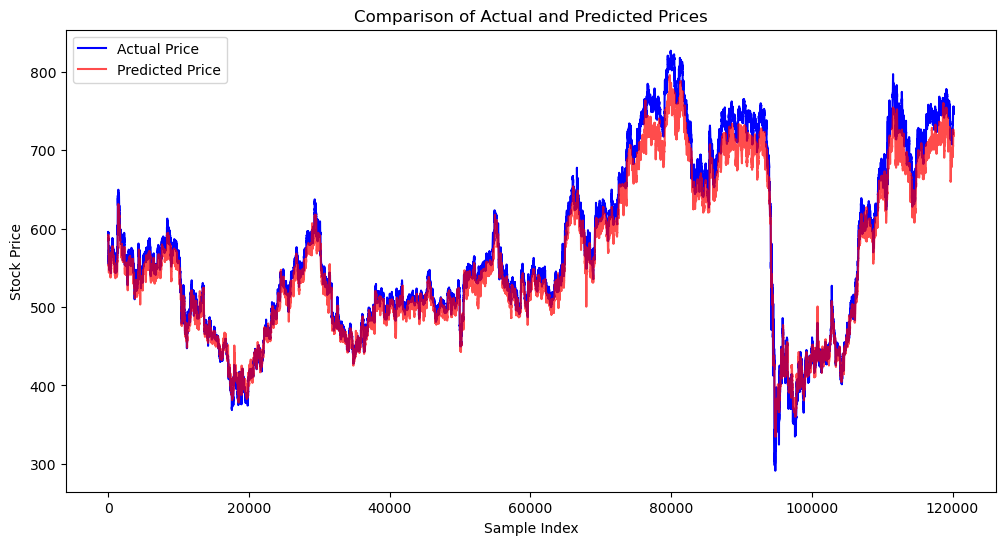

In [79]:
# Train
# Rescale the outputs back to the original scale
y_train_continuous_rescaled = close_scaler.inverse_transform(y_train_continuous.reshape(-1, 1))
y_pred_continuous_rescaled = close_scaler.inverse_transform(y_pred_continuous.reshape(-1, 1))

# Visualization of prediction vs actual for the continuous model
plt.figure(figsize=(12, 6))
plt.plot(y_train_continuous_rescaled, label='Actual Price', color='blue')
plt.plot(y_pred_continuous_rescaled, label='Predicted Price', color='red', alpha=0.7)
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [80]:
continuous_trading_strategy(init_amount, y_train_continuous_rescaled, y_pred_continuous_rescaled)

Initial Amount: 10000
Final Balance:  13814.650
Total Transactions: 80304
Buys: 60021, Sells: 20283
Trading Duration: 10013.25 hours
Trades per hour: 8.019773799715377
Mean Gain/Loss Percentage per transaction: 0.00048%
Gain/Loss Percentage: 38.15%
Baseline Scenario:
Baseline Gain/Loss Percentage: 26.13%


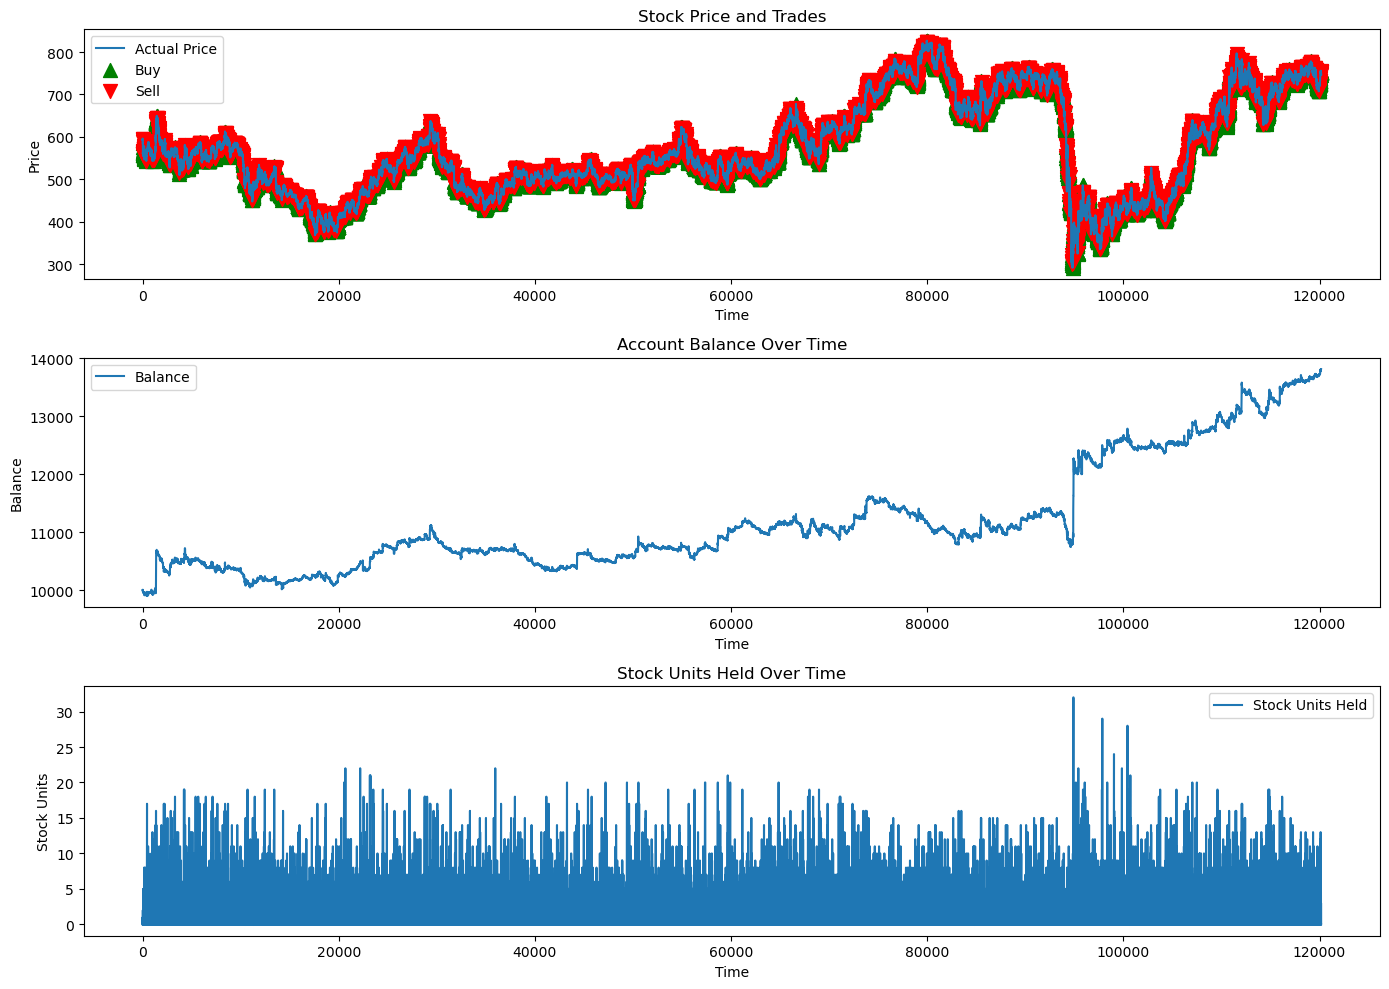

In [81]:
visualize_trading_strategy_continuous(init_amount, y_train_continuous_rescaled, y_pred_continuous_rescaled)

In [82]:
binary_trading_strategy(init_amount, y_train_continuous_rescaled, y_pred_binary)

Initial Amount: 10000
Final Balance: 13526.600000000171
Total Transactions: 24723
Buys: 22681, Sells: 2042
Trading Duration: 10013.25 hours
Trades per hour: 2.4690285371882257
Gain/Loss Percentage: 35.27%
Mean Gain/Loss Percentage per transaction: 0.00143%
Baseline Scenario:
Baseline Gain/Loss Percentage: 26.13%


In [83]:
combined_trading_strategy(init_amount, y_train_continuous_rescaled, y_pred_continuous_rescaled, y_pred_binary)

Initial Amount: 10000
Final Balance: 14845.850000000139
Total Transactions: 18351
Buys: 16714, Sells: 1637
Trading Duration: 10013.25 hours
Trades per hour: 1.8326717099842709
Gain/Loss Percentage: 48.46%
Mean Gain/Loss Percentage per transaction: 0.00264%
Baseline Scenario:
Baseline Gain/Loss Percentage: 26.13%


### shorter timespan

In [84]:
# Evaluate binary model
print("Binary Classification Report:")
binary_thresh = 0.488

print(classification_report(y_train_binary[:1000], (y_pred_binary[:1000] > binary_thresh).astype(int)))

Binary Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.34      0.41       512
           1       0.49      0.66      0.56       488

    accuracy                           0.49      1000
   macro avg       0.50      0.50      0.48      1000
weighted avg       0.50      0.49      0.48      1000



In [100]:
# Evaluate continuous model converted to binary
print("Continuous Model Converted to Binary Classification Report:")
print(classification_report(y_train_binary[:1000], y_pred_binary_from_cont[:1000]))

Continuous Model Converted to Binary Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.57      0.55       512
           1       0.52      0.48      0.50       488

    accuracy                           0.53      1000
   macro avg       0.53      0.53      0.53      1000
weighted avg       0.53      0.53      0.53      1000



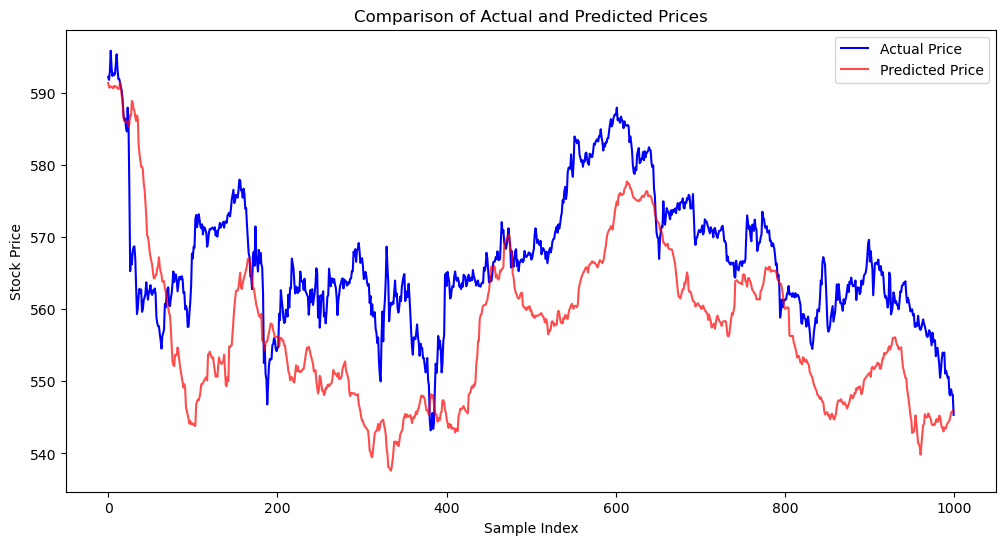

In [86]:
# Visualization of prediction vs actual for the continuous model
plt.figure(figsize=(12, 6))
plt.plot(y_train_continuous_rescaled[:1000], label='Actual Price', color='blue')
plt.plot(y_pred_continuous_rescaled[:1000], label='Predicted Price', color='red', alpha=0.7)
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [87]:
continuous_trading_strategy(init_amount, y_train_continuous_rescaled[:1000], y_pred_continuous_rescaled[:1000])

Initial Amount: 10000
Final Balance:  9937.950
Total Transactions: 623
Buys: 451, Sells: 172
Trading Duration: 83.25 hours
Trades per hour: 7.483483483483483
Mean Gain/Loss Percentage per transaction: -0.00100%
Gain/Loss Percentage: -0.62%
Baseline Scenario:
Baseline Gain/Loss Percentage: -7.92%


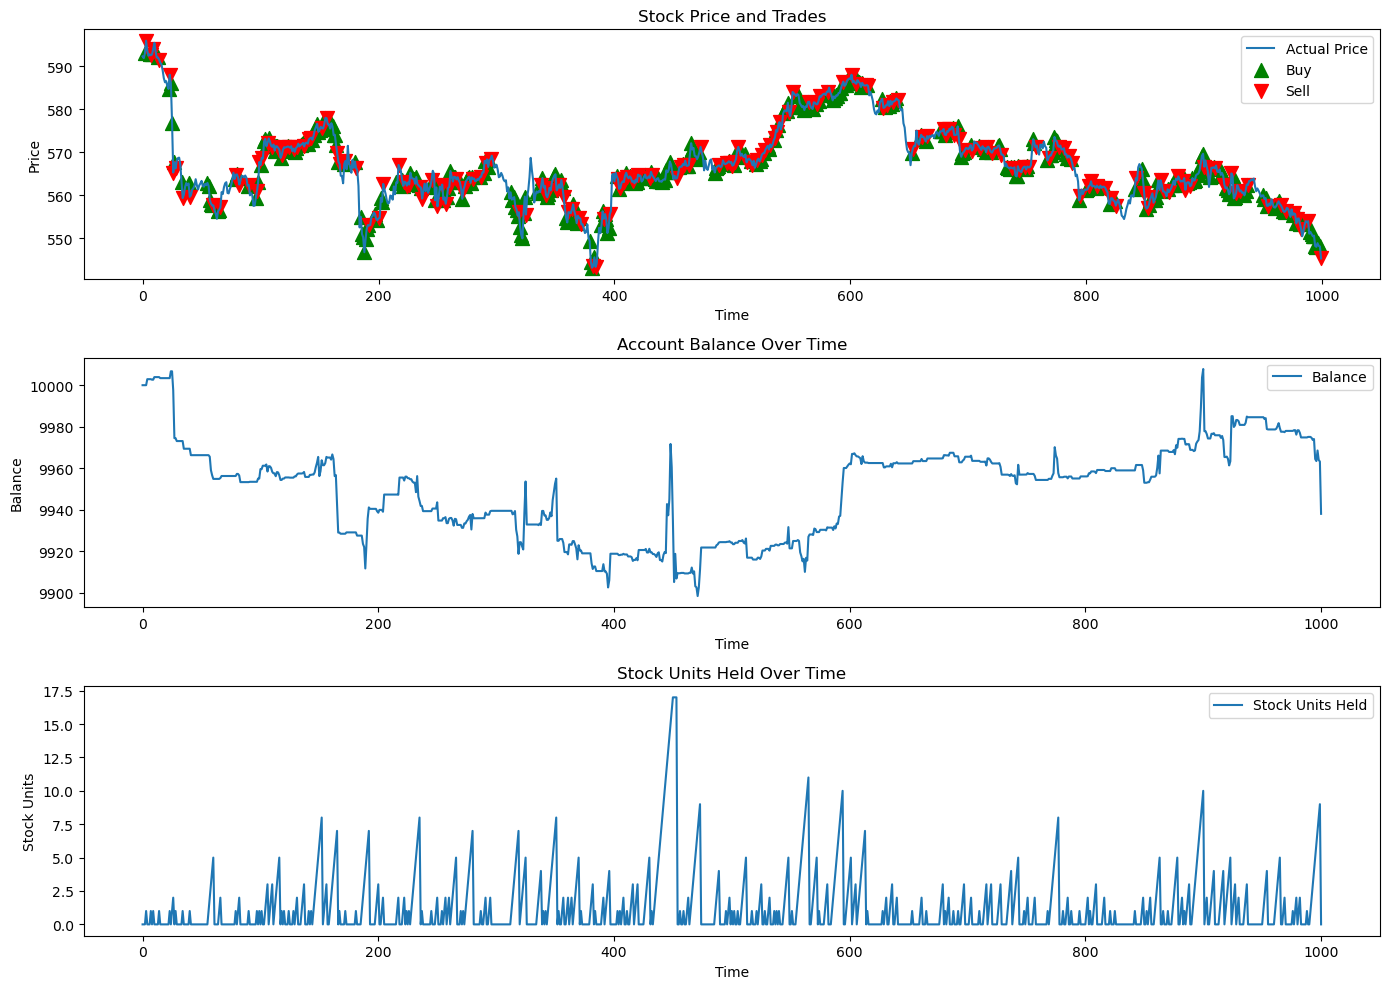

In [88]:
visualize_trading_strategy_continuous(init_amount, y_train_continuous_rescaled[:1000], y_pred_continuous_rescaled[:1000])

In [89]:
binary_trading_strategy(init_amount, y_train_continuous_rescaled[:1000], y_pred_binary[:1000])

Initial Amount: 10000
Final Balance: 9225.350000000013
Total Transactions: 289
Buys: 263, Sells: 26
Trading Duration: 83.25 hours
Trades per hour: 3.4714714714714714
Gain/Loss Percentage: -7.75%
Mean Gain/Loss Percentage per transaction: -0.02680%
Baseline Scenario:
Baseline Gain/Loss Percentage: -7.92%


In [90]:
combined_trading_strategy(init_amount, y_train_continuous_rescaled[:1000], y_pred_continuous_rescaled[:1000], y_pred_binary[:1000])

Initial Amount: 10000
Final Balance: 9533.6
Total Transactions: 200
Buys: 183, Sells: 17
Trading Duration: 83.25 hours
Trades per hour: 2.4024024024024024
Gain/Loss Percentage: -4.66%
Mean Gain/Loss Percentage per transaction: -0.02332%
Baseline Scenario:
Baseline Gain/Loss Percentage: -7.92%
